In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
from datetime import datetime
import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

In [2]:
from financepy.utils import *
from financepy.products.equity import *
from financepy.market.curves import *
from financepy.products.rates import *
from financepy.models.hw_tree import HWTree
from financepy.models.bk_tree import BKTree
from financepy.models.bdt_tree import BDTTree

####################################################################
# FINANCEPY BETA Version 0.260 - This build:  22 Nov 2022 at 13:42 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



## Q1 - Black-Scholes-Merton Hedging

### a - How to value an Equity Vanilla Options
To do so we will use the Black-Scholes formula: <br>
$$ C(O,T) = S(0)*N(d_{1}) - K*e^{-rt}*N(d_{2})\\ $$

Where: 
  $$ d_{1} = \frac{ln(\frac{S}{K})+(r+\frac{\sigma^{2}}{2})*T}{\sigma*\sqrt{T}} \\ $$
  $$ d_{2} = \frac{ln(\frac{S}{K})+(r-\frac{\sigma^{2}}{2})*T}{\sigma*\sqrt{T}} \\ $$

To price a Equity Vanilla Option we need the following information:
- Starting Date: $t_{0}$
- The expiry date: T
- The Stock price at time T: S(T)
- Strike Price: K
- The volatility $\sigma$
- Risk-free rate: r (constant)
- Dividend yield: q = 0



In [3]:
#1- Define the starting date using Date(DD,MM,YYYY)
valuation_date = Date(1, 5, 2015)

In [4]:
#2- Define the expiry date using .addyears
expiry_date = valuation_date.add_years(0.5) #Here we add half a year i.e 6 months

3- Then we call **EquityVanilla** Option from financepy, it handles simple European-style call and put options on a dividend paying stock with analytical and monte-carlo valuations. In the function we have to specify:
- expiry_date
- valuation_date
- type of option: **OptionTypes.EUROPEAN_CALL** or **OptionTypes.EUROPEAN_PUT**

**type_option = EquityVanillaOption(expiry_date, strike_price, OptionTypes.EUROPEAN_XXXX)**

4 - We have to define then a discount curve and a divididend curve. 
- **discount_curve = DiscountCurveFlat(valuation_date, interest_rate)**
- **dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)**

Remarks:
- In the BS model interest rates are constant so we use the *Flat Curve* model
- In the BS model there is no dividend so we use the *Flat Curve* model for the *dividend_curve* with *dividend_yield=0*

5- We specify the model used:
- **model = BlackScholes($\sigma$)**

6- We now have all the information. We can call value: <br>
- **type_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)**

### b - Calculate the option Delta.
financepy already has a function that compute the greeks (delta, gamma, vega, and rho) if the inputs are defined. It goes as follows:
- **type_option.delta(valuation_date, stock_price, discount_curve, dividend_curve, model)**

*delta* can be repalced by *gamma*, *rho*, or *vega*

### c- OptionSim that simulates the delta hedging of a European call option from trade date until expiry.

Merton's idea is that to be hedge when the trader sell an option (here a call), s/he will need to buy $\Delta$ of the stock.
So, to be hedged, we need to create a portfolio $\Pi$, the value of the portfolio is: 
$$ \Pi_{t} = -C_{t} + \Delta_{t} * S_{t} + CashBalance_t $$

When we re-balance our portfolio the value of $\Delta$ might change wo we will have to adjust our holdings of the stock. To buy the stock we will have to borrow money at the risk free-rate.

How will we write this in our code?
1. **Initialisation t=0:**

We have to initialise for t=0, when we sell the call option and buy delta (computed with FinancePy) shares of the stock to be hedged. We can set the inital value of our cash balance according to our buy and sell.

2. **Anytime t after initialisation:**

First, we will compute the new stock price. Then, compute the updated value of delta with FinancePy. If delta increases or decreases we will adjuste our holding by buying or selling shares. Finally, we will impact the buy and sell in the cash balance.

Futhermore, for all time t we will compute the error which will be the difference between the value of our portfolio and the option payoff.

In [5]:
def OptionSim(valuation_date, n_years, steps_year, strike_price, stock_price, interest_rate,
              stock_price_drift, dividend_yield, volatility):
    
    # Define dt
    dt = 1/steps_year
    
    # Define expiry date
    expiry_date = valuation_date.add_years(n_years)
    
    # Define the option: Call option
    call_option = EquityVanillaOption(expiry_date, strike_price, OptionTypes.EUROPEAN_CALL)
    
    # Model: BlackScholes with constant volatility
    model = BlackScholes(volatility)
    
    #Loop on the rebalancing date
    #Test if there is an error in the input with a date above expiry
    if valuation_date.add_years(dt) > expiry_date: 
        print("No rebalancing")
    
    else:
        nb_rebalancing = int(n_years*steps_year) #number of rebalancing
        init = 0
        shares = 0
        n_stock_price = stock_price
        
        #Loop on the rebalancing dates
        for k in range(nb_rebalancing+1):
            
            #Set new valuation date
            new_valuation_date = valuation_date.add_years(k*dt)
            
            #Compute the stock price
            if init !=0: #if t=0 we don't compute a new stock price 
                Z = np.random.normal(loc=0.0, scale=1.0, size=1)[0]
                #Exact formula
                n_stock_price = n_stock_price * exp((stock_price_drift-dividend_yield-(volatility**2)/2)* dt 
                                                   + volatility * Z * sqrt(dt))
            
            #Call payoff
            call_payoff = max(n_stock_price - strike_price, 0)
            
            #Curve with the new valuation date
            discount_curve = DiscountCurveFlat(new_valuation_date, interest_rate)
            dividend_curve = DiscountCurveFlat(new_valuation_date, dividend_yield)
            
            #Compute
            call_value = call_option.value(new_valuation_date, n_stock_price, discount_curve, dividend_curve, model)
            call_delta = call_option.delta(new_valuation_date, n_stock_price, discount_curve, dividend_curve, model)
            
            #Initialization of the cash balance
            if init==0:
                cash_balance = call_value
                init+=1
            else:  
                #he cash balance grows at r
                cash_balance = cash_balance*np.exp(interest_rate*(dt))
                
            #Adjust the cash balance if we sold or bought shares
            cash_balance = -(call_delta - shares)*n_stock_price + cash_balance
            shares = call_delta
            
            #Compute the value of the hedging portoflio and the error associated
            hedging_pf = cash_balance + call_delta*n_stock_price
            error = hedging_pf - call_payoff
        
        #Create the tuple to return
        tuple_to_return = (n_stock_price, call_payoff, call_delta, cash_balance,
                           hedging_pf ,error)
        
    return tuple_to_return

### d- Write another function to calculate the hedging error over 1,000 different paths.

To do so we only have to run 1,000 times over **OptionSim** as the path for the stock price is created randomly.

In [6]:
def test_hedging(n_paths, valuation_date, n_years, steps_year, strike_price, stock_price,
                 interest_rate, stock_price_drift, dividend_yield, volatility):
    #Initialization of the list of errors
    error_df = pd.DataFrame(columns=["stock_price","error"])
    
    #Loop on the nb of paths to run n_paths times OptionSim
    for path in range(n_paths):
        #Run one simulation by calling OptionSim
        sim = OptionSim(valuation_date, n_years, steps_year, strike_price, stock_price, interest_rate,
              stock_price_drift, dividend_yield, volatility)
        
        #Append error and stock price to the dataframe
        error_df.loc[len(error_df)] = [sim[0], sim[-1]]
    
    #Return the dataframe
    return error_df

### e- Plot hedging strategy
The call option has the following characteristics:
- S(0) = 100
- K = 100
- r = 5%
- T = 1.0
- σ = 20%
- µ = r

Below, we will have for each value of N (12, 52, and 252):
1. Scatterplot of the hedging error (y-axis) versus the terminal stock price (x-axis)
2. Scatterplot of the payoff of our hedging portfolio (y-axis) versus the terminal stock price

#### Monthly Rebalancing - N = 12

In [7]:
%%time
random.seed(123)
#Call test_hedging defined above
error_m_df = test_hedging(n_paths = 1000, valuation_date = Date(2, 12, 2022), n_years=1 , steps_year= 12, strike_price= 100,
                    stock_price= 100, interest_rate = 0.05, stock_price_drift=0.05, dividend_yield=0, volatility=0.2)

Wall time: 1min 25s


In [8]:
%%time
random.seed(123)
#Dataframe that will store the data
data_m_df = pd.DataFrame(columns=["stock_price", "payoff", "Hedge_pf", "error"])

for i in range(1000): # Model for 1000 paths
    #Run one simulation 
    sim = OptionSim(valuation_date = Date(2, 12, 2022), n_years=1 , steps_year= 12, strike_price= 100,
                    stock_price= 100, interest_rate = 0.05, stock_price_drift=0.05, dividend_yield=0, volatility=0.2)
    #Assigne values
    stock_price = sim[0]
    payoff= sim[1]
    Hedge_pf= sim[4]
    error = sim[5]
    
    #Add to the dataframe
    data_m_df.loc[len(data_m_df)] = [stock_price, payoff, Hedge_pf, error]

Wall time: 1min 28s


In [9]:
#To save time for re-run save the dataframe in a CSV file
#Update the path to match your computer if needed
data_m_df.to_csv(".\monthly_data.csv")

#### Plotting Data

(-8.0, 8.0)

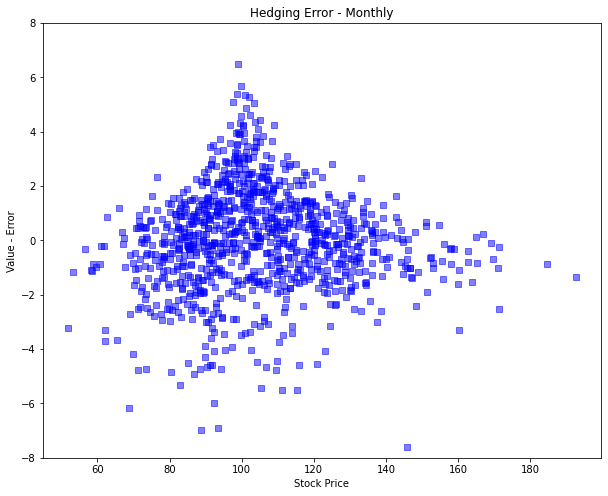

In [10]:
#Create the scatter plot
fig,ax= plt.subplots(figsize=(10,8))
ax.scatter(error_m_df.stock_price, error_m_df.error, marker="s", color="blue", alpha=0.5)

#Set axis, title & legend
ax.set_title("Hedging Error - Monthly")
ax.set_xlabel("Stock Price")
ax.set_ylabel("Value - Error")

#Set y-axis limit to compare different rebalancing frequency
ax.set_ylim(-8,8)

(-10.0, 100.0)

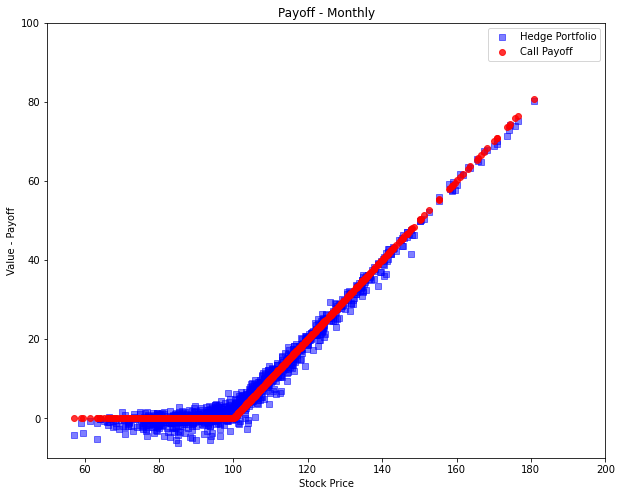

In [11]:
#Create the scatter plot
fig,ax= plt.subplots(figsize=(10,8))
ax.scatter(data_m_df.stock_price, data_m_df.Hedge_pf, marker="s", color="blue", label= "Hedge Portfolio", alpha=0.5)
ax.scatter(data_m_df.stock_price, data_m_df.payoff, marker="o", color="red", label= "Call Payoff", alpha=0.8)

#Set axis, title & legend
ax.set_title("Payoff - Monthly")
ax.set_xlabel("Stock Price")
ax.set_ylabel("Value - Payoff")
ax.legend()

#Set axis limit
ax.set_xlim(50,200)
ax.set_ylim(-10,100)

#### Weekly Rebalancing - N = 52

In [12]:
%%time
random.seed(123)
#Call test_hedging defined above
error_w_df = test_hedging(n_paths = 1000, valuation_date = Date(2, 12, 2022), n_years=1 , steps_year= 52, strike_price= 100,
                    stock_price= 100, interest_rate = 0.05, stock_price_drift=0.05, dividend_yield=0, volatility=0.2)

Wall time: 2min 22s


In [13]:
%%time
random.seed(123)
#Dataframe that will store the data
data_w_df = pd.DataFrame(columns=["stock_price", "payoff", "Hedge_pf", "error"])
for i in range(1000): # Model for 1000 paths
    #Simulation
    sim = OptionSim(valuation_date = Date(2, 12, 2022), n_years=1 , steps_year= 52, strike_price= 100,
                    stock_price= 100, interest_rate = 0.05, stock_price_drift=0.05, dividend_yield=0, volatility=0.2)
    #Assign value
    stock_price = sim[0]
    payoff= sim[1]
    Hedge_pf= sim[4]
    error = sim[5]
    
    #Add to df
    data_w_df.loc[len(data_w_df)] = [stock_price, payoff, Hedge_pf, error]

Wall time: 1min 55s


In [14]:
#To save time for re-run save the dataframe in a CSV file
#Update the path to match your computer if needed
data_m_df.to_csv(".\weekly_data.csv")

#### Plotting

(-8.0, 8.0)

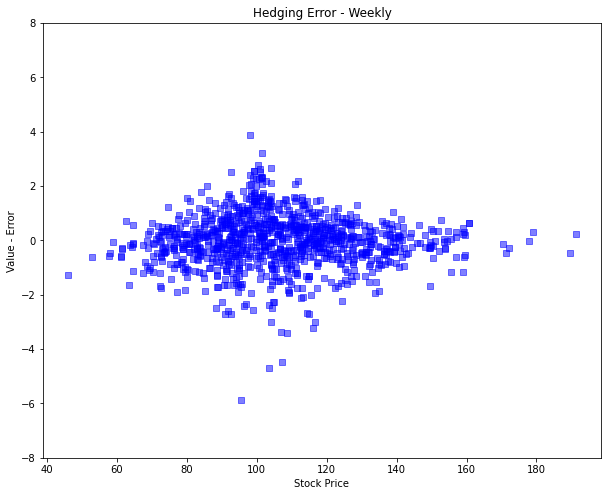

In [15]:
#Create the scatter plot
fig,ax= plt.subplots(figsize=(10,8))
ax.scatter(error_w_df.stock_price, error_w_df.error, marker="s", color="blue", alpha=0.5)

#Set axis, title & legend
ax.set_title("Hedging Error - Weekly")
ax.set_xlabel("Stock Price")
ax.set_ylabel("Value - Error")

#Set y-axis limit to compare different rebalancing frequency
ax.set_ylim(-8,8)

(-10.0, 100.0)

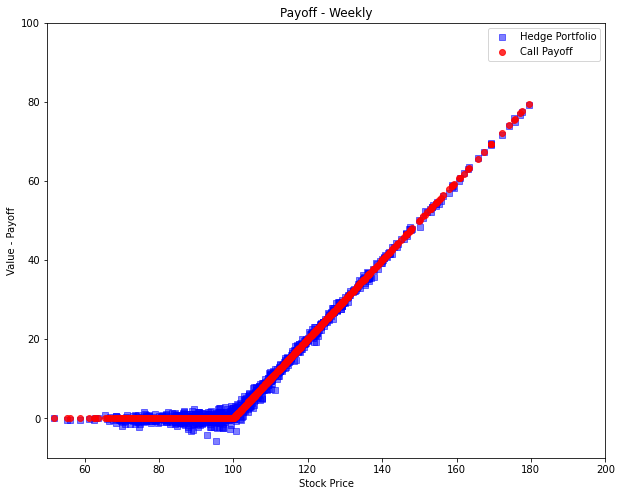

In [16]:
#Create the scatter plot
fig,ax= plt.subplots(figsize=(10,8))
ax.scatter(data_w_df.stock_price, data_w_df.Hedge_pf, marker="s", color="blue", label= "Hedge Portfolio", alpha=0.5)
ax.scatter(data_w_df.stock_price, data_w_df.payoff, marker="o", color="red", label= "Call Payoff", alpha=0.8)

#Set axis, title & legend
ax.set_title("Payoff - Weekly")
ax.set_xlabel("Stock Price")
ax.set_ylabel("Value - Payoff")
ax.legend()

#Set axis limit
ax.set_xlim(50,200)
ax.set_ylim(-10,100)

#### Daily Rebalancing N = 252

In [17]:
%%time
random.seed(123)
#Call test_hedging defined above
error_d_df = test_hedging(n_paths = 1000, valuation_date = Date(2, 12, 2022), n_years=1 , steps_year= 252, strike_price= 100,
                    stock_price= 100, interest_rate = 0.05, stock_price_drift=0.05, dividend_yield=0, volatility=0.2)

Wall time: 9min 39s


In [18]:
%%time
random.seed(123)
#Dataframe that will store the data
data_d_df = pd.DataFrame(columns=["stock_price", "payoff", "Hedge_pf", "error"])

for i in range(1000): #Model for 1000 paths
    #Simulation
    sim = OptionSim(valuation_date = Date(2, 12, 2022), n_years=1 , steps_year= 252, strike_price= 100,
                    stock_price= 100, interest_rate = 0.05, stock_price_drift=0.05, dividend_yield=0, volatility=0.2)
    #Assign value
    stock_price = sim[0]
    payoff= sim[1]
    Hedge_pf= sim[4]
    error = sim[5]
    
    #Add to df
    data_d_df.loc[len(data_d_df)] = [stock_price, payoff, Hedge_pf, error]

Wall time: 9min 26s


In [19]:
#To save time for re-run save the dataframe in a CSV file
#Update the path to match your computer if needed
data_m_df.to_csv(".\daily_data.csv")

(-8.0, 8.0)

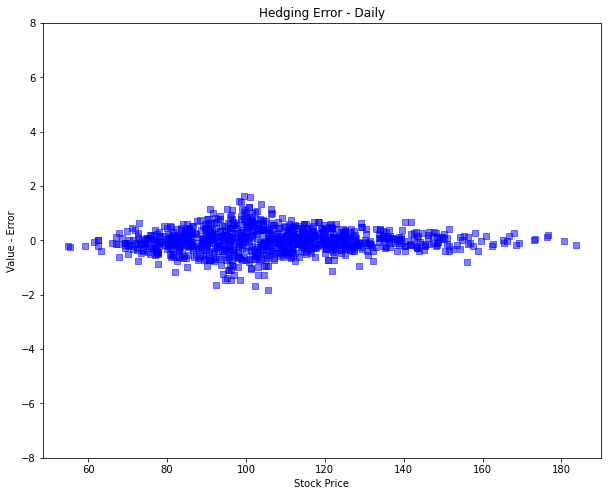

In [20]:
#Create the scatter plot
fig,ax= plt.subplots(figsize=(10,8))
ax.scatter(error_d_df.stock_price, error_d_df.error, marker="s", color="blue", alpha=0.5)

#Set axis, title & legend
ax.set_title("Hedging Error - Daily")
ax.set_xlabel("Stock Price")
ax.set_ylabel("Value - Error")

#Set y-axis limit to compare different rebalancing frequency
ax.set_ylim(-8,8)

(-10.0, 100.0)

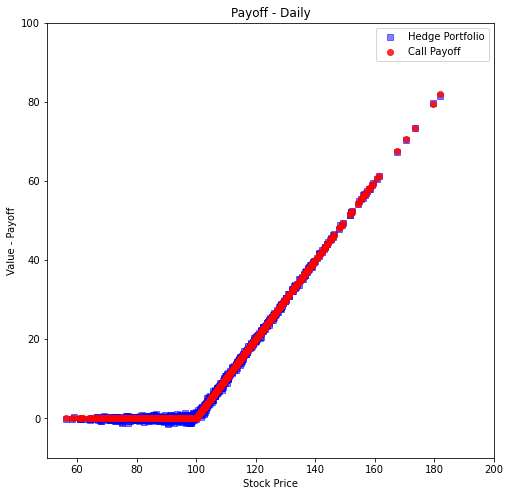

In [21]:
#Create the scatter plot
fig,ax= plt.subplots(figsize=(8,8))
ax.scatter(data_d_df.stock_price, data_d_df.Hedge_pf, marker="s", color="blue", label= "Hedge Portfolio", alpha=0.5)
ax.scatter(data_d_df.stock_price, data_d_df.payoff, marker="o", color="red", label= "Call Payoff", alpha=0.8)

#Set axis, title & legend
ax.set_title("Payoff - Daily")
ax.set_xlabel("Stock Price")
ax.set_ylabel("Value - Payoff")
ax.legend()

#Set axis limit
ax.set_xlim(50,200)
ax.set_ylim(-10,100)

#### Observation

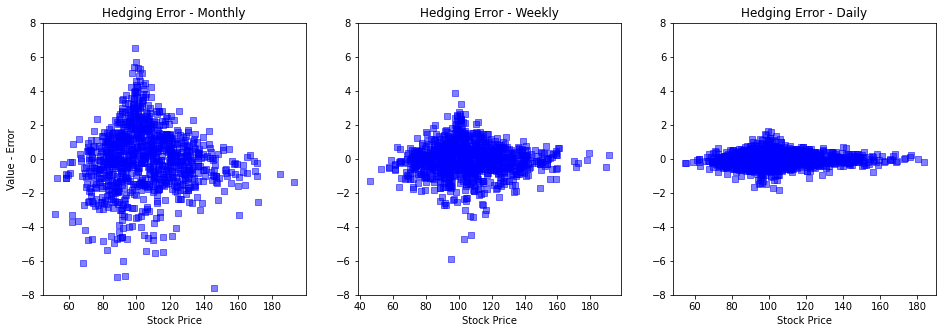

In [22]:
fig, ax = plt.subplots(1,3, figsize=(16,5))

ax[0].scatter(error_m_df.stock_price, error_m_df.error, marker="s", color="blue", alpha=0.5)
ax[1].scatter(error_w_df.stock_price, error_w_df.error, marker="s", color="blue", alpha=0.5)
ax[2].scatter(error_d_df.stock_price, error_d_df.error, marker="s", color="blue", alpha=0.5)

#Set axis, title & legend
ax[0].set_title("Hedging Error - Monthly")
ax[1].set_title("Hedging Error - Weekly")
ax[2].set_title("Hedging Error - Daily")

for i in range (3):
    ax[i].set_xlabel("Stock Price")
ax[0].set_ylabel("Value - Error")

#Set y-axis limit to compare different rebalancing frequency
for i in range (3):
    ax[i].set_ylim(-8,8)

We see that the **higher the heding frequency the lower the error hedging error**. A trader who wants to be perfectly hedge when he sells an option should hedge on a daily basis. This is in perfect world with no friction but what happen when we take into account those frictions ?

### f-  mean and variance of this option hedging error over 1,000 different paths

In [23]:
print("-"*20)
print("Monthly Rebalancing")
print("The mean of the error over 1,000 paths is:", round(data_m_df.error.mean(),3))
print("The variance of the error over 1,000 paths is:", round(data_m_df.error.var(),3))
print("-"*20)
print("Weekly Rebalancing")
print("The mean of the error over 1,000 paths is:", round(data_w_df.error.mean(),3))
print("The variance of the error over 1,000 paths is:", round(data_w_df.error.var(),3))
print("-"*20)
print("Daily Rebalancing")
print("The mean of the error over 1,000 paths is:", round(data_d_df.error.mean(),3))
print("The variance of the error over 1,000 paths is:", round(data_d_df.error.var(),3))
print("-"*20)

--------------------
Monthly Rebalancing
The mean of the error over 1,000 paths is: -0.075
The variance of the error over 1,000 paths is: 3.361
--------------------
Weekly Rebalancing
The mean of the error over 1,000 paths is: -0.021
The variance of the error over 1,000 paths is: 0.985
--------------------
Daily Rebalancing
The mean of the error over 1,000 paths is: -0.009
The variance of the error over 1,000 paths is: 0.191
--------------------


**Obersation**
- We see that the mean for **montly rebalancing is lower than the mean error the monthly rebalancing** but when looking at the variance, we see that the **variance for a monthly rebalancing is more than 4 times higher than with a weekly rebalancing**.
- The **Daily rebalancing** has the lowest mean error and variance.

This confirms what we saw in the graphs above and the advantage of a higher rebalancing frequency.

### g- Let's re-run for different value of the drift  µ = 2.5%, 5.0%, 7.5%, 10% but with 10,000 paths

To make the process quicker we will parallelization. To do so, in Jupyter you need to call a .py file with the function you are using. The function found below are stored in another file called "*lib_function.py*"

In [24]:
def test_para(mu):
    
    #Dataframe that will store the data
    df = pd.DataFrame(columns=["stock_price", "payoff", "Hedge_pf", "error"])

    for i in range(1000): #Model for 1000 paths
        #Simulation
        sim = OptionSim(valuation_date = Date(2, 12, 2022), n_years=1 , steps_year= 52, strike_price= 100,
                        stock_price= 100, interest_rate = 0.05, stock_price_drift= mu, dividend_yield=0, volatility=0.2)
        #Assign value
        stock_price = sim[0]
        payoff= sim[1]
        Hedge_pf= sim[4]
        error = sim[5]

        #Add to df
        df.loc[len(df)] = [stock_price, payoff, Hedge_pf, error]
    return df

In [25]:
%%time
#Define the list of mu
mu_list = [0.025, 0.05, 0.075, 0.1]
#Compute and assign to dataframe
mu_25_df, mu_50_df, mu_75_df, mu_100_df = [test_para(mu) for mu in mu_list]

Wall time: 8min 35s


In [26]:
#To save time for re-run save the dataframe in a CSV file
mu_25_df.to_csv(".\mu_25_data.csv")
mu_50_df.to_csv(".\mu_50_data.csv")
mu_75_df.to_csv(".\mu_75_data.csv")
mu_100_df.to_csv(".\mu_100_data.csv")

In [27]:
#Create a dataframe
data = {
    "2.5%":[mu_25_df.error.mean(), mu_25_df.error.var()],
    "5.0%":[mu_50_df.error.mean(), mu_50_df.error.var()],
    "7.5%":[mu_75_df.error.mean(), mu_75_df.error.var()],
    "10%":[mu_100_df.error.mean(), mu_100_df.error.var()],
}
mu_df = pd.DataFrame(data, index=["Monthly Rebalacing - Error", "Monthly Rebalacing - Variance"])

#Display
mu_df.round(3)

2.5%   5.0%   7.5%    10%
Monthly Rebalacing - Error    -0.022  0.010  0.026  0.005
Monthly Rebalacing - Variance  0.972  0.954  0.837  0.821

**Observation** - We see that the process does not just work **on average**. The strategy works well for different value of the drift with a mean error and variance close for eah value of $\mu$.

## Q2 - Transaction Costs

### Q2.a - Improve OptionSim to account for transaction costs
The relative bid-ask spread is defined as followed: 
$$\phi = \frac{S_{ask}-S_{bid}}{S_{mid}}$$

Here, $\phi$ will be a new input in the function to account for transcation cost with:

- Buying price = S*(1+$\frac{\phi}{2}$)
- Selling price = S*(1-$\frac{\phi}{2}$)

In [28]:
def OptionSim2(valuation_date, n_years, steps_year, strike_price, stock_price, interest_rate,
              stock_price_drift, dividend_yield, volatility, transaction_cost):
    
    # Define dt
    dt = 1/steps_year
    
    # Define expiry date
    expiry_date = valuation_date.add_years(n_years)
    
    # Define the option
    call_option = EquityVanillaOption(expiry_date, strike_price, OptionTypes.EUROPEAN_CALL)
    
    # Model: BS
    model = BlackScholes(volatility)
    
    #Loop on the rebalancing date
    if valuation_date.add_years(dt) > expiry_date:
        print("No rebalancing")
        
    else:
        nb_rebalancing = int(n_years*steps_year)
        init = 0
        shares = 0
        n_stock_price = stock_price
        
        for k in range(nb_rebalancing+1):
            
            #Set new valuation date
            new_valuation_date = valuation_date.add_years(k*dt)
            
            if init !=0:
                #Compute the stock price
                Z = np.random.normal(loc=0.0, scale=1.0, size=1)[0]
                #Exact formula
                n_stock_price = n_stock_price * exp((stock_price_drift-dividend_yield-(volatility**2)/2)* dt 
                                                   + volatility * Z * sqrt(dt))
            
            #Call payoff
            call_payoff = max(n_stock_price - strike_price, 0)
            
            #Curve with the new valuation date
            discount_curve = DiscountCurveFlat(new_valuation_date, interest_rate)
            dividend_curve = DiscountCurveFlat(new_valuation_date, dividend_yield)
            
            #Compute
            call_value = call_option.value(new_valuation_date, n_stock_price, discount_curve, dividend_curve, model)
            call_delta = call_option.delta(new_valuation_date, n_stock_price, discount_curve, dividend_curve, model)
            
            #Initialized the cash balance
            if init==0:
                cash_balance = call_value
                init+=1
            else:  
                #Growth at r
                cash_balance = cash_balance*np.exp(interest_rate*(dt))
                
            #Adjust the cash balance if we sold or bought shares
            ############################################################
            #Here we are also going to adjust for the transaction price
            # (stock_price + 0.5*relative_bid_ask) if we buy shares
            # (stock_price - 0.5*relative_bid_ask) if we sell shares
            ############################################################
            transac_cost = np.sign(call_delta - shares)*transaction_cost*0.5
            cash_balance = -(call_delta - shares)*n_stock_price*(1 + transac_cost) + cash_balance                         
            
            #Nb of current shares equal to the delta
            shares = call_delta
            
            #Compute the value of the hedging portoflio and the error associated
            hedging_pf = cash_balance + call_delta*n_stock_price
            error = hedging_pf - call_payoff
        
        #Create the tuple to return
        tuple_to_return = (n_stock_price, call_payoff, call_delta, cash_balance,
                           hedging_pf ,error)
        
    return tuple_to_return

### Q2.b - Mean Hedging Error
The call option has the following characteristics:
- S(0) = 100
- K = 100
- r = 5%
- T = 1.0
- σ = 20%.
- µ = r = 5%

**Number of paths**: 1,000 <br>

**Variables**
- **Hedging frequency**: 12, 52, and 252
- **Transaction costs** $\phi$: 0.5%, 1.0%, and 2.0%

In [29]:
def test_phi(phi, freq):
    
    #Dataframe that will store the data
    df = pd.DataFrame(columns=["stock_price", "payoff", "Hedge_pf", "error"])

    for i in range(1000): #Model for 1000 paths
        #Simulation
        sim = OptionSim2(valuation_date = Date(2, 12, 2022), n_years=1 , steps_year= freq, strike_price= 100,
                        stock_price= 100, interest_rate = 0.05, stock_price_drift= 0.05, dividend_yield=0,
                        volatility=0.2, transaction_cost=phi)
        #Assign value
        stock_price = sim[0]
        payoff= sim[1]
        Hedge_pf= sim[4]
        error = sim[5]

        #Add to df
        df.loc[len(df)] = [stock_price, payoff, Hedge_pf, error]
    return df

1- Let's run for a **monthly hedging**

In [30]:
%%time
random.seed(123)
#List of phi
phi_list = [0.005, 0.01, 0.02]
#Monthly rebalancing
N = 12

phi_m_df = [test_phi(phi, N) for phi in phi_list]

Wall time: 1min 32s


2- Let's run for a **weekly hedging**

In [31]:
%%time
random.seed(123)
#List of phi
phi_list = [0.005, 0.01, 0.02]
#Weekly rebalancing
N = 52

phi_w_df = [test_phi(phi, N) for phi in phi_list]

Wall time: 5min 44s


3- Let's run for a **daily hedging**

In [32]:
%%time
random.seed(123)
#List of phi
phi_list = [0.005, 0.01, 0.02]
#Daily rebalancing
N = 252

phi_d_df = [test_phi(phi, N) for phi in phi_list]

Wall time: 27min 10s


In [33]:
#Let's display a table with the average of the error for each phi and rebalancing frequency
phi_df = pd.DataFrame(columns=["monthly", "weekly", "daily"], index=["0.5%", "1.0%","2.0%"])

#fill the df
phi_df.monthly = [phi_m_df[i].error.mean() for i in range (3)]
phi_df.weekly = [phi_w_df[i].error.mean() for i in range (3)]
phi_df.daily = [phi_d_df[i].error.mean() for i in range (3)]

#Display & round values
phi_df.round(3)

monthly  weekly  daily
0.5%   -0.409  -0.725 -1.440
1.0%   -0.969  -1.462 -2.862
2.0%   -1.925  -2.898 -5.666

**Two observations can be made**
1. We see that the **the error increases with the rebalancing frequency**. It makes sense as the more we rebalance the more we will pay the transaction fees thus it will negatively affect the cash account.
2. We also see that the **error increases with the transaction costs**. It also makes sense because with higher transaction costs it's more expensive to sell or buy the stock. 

We see that overall when accounting for transaction costs, the error increases with the rebalancement frequency and the transaction costs. The **transactions costs offsets the benefit of rebalancing frequently**. Thus, there is a **tradeoff** between rebalancing frequently and paying transactions costs.

**Let's see how the transaction cost impact our hedging with the plots**

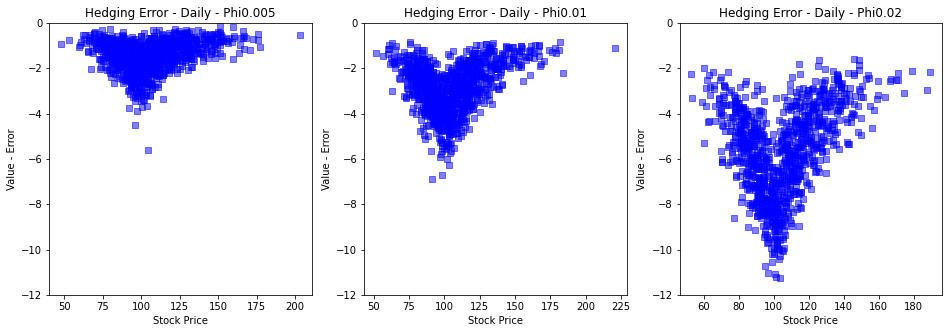

In [34]:
#Plotting the error the daily rebalancing for three different transaction costs
#phi = 0.5%, 1%, and 2%
phi_list = [0.005, 0.01, 0.02]

fig, ax = plt.subplots(1,3, figsize=(16,5))

#loop on phi
for i in range (3):
    ax[i].scatter(phi_d_df[i].stock_price, phi_d_df[i].error, marker="s", color="blue", alpha=0.5)

    #Set axis, title & legend
    ax[i].set_title("Hedging Error - Daily - Phi" + str(phi_list[i]))
    ax[i].set_xlabel("Stock Price")
    ax[i].set_ylabel("Value - Error")
    
    #Set y-axis limit to compare different rebalancing frequency
    ax[i].set_ylim(-12,0)

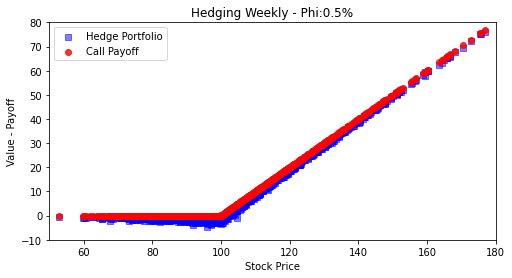

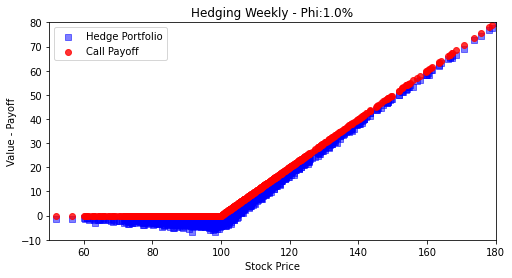

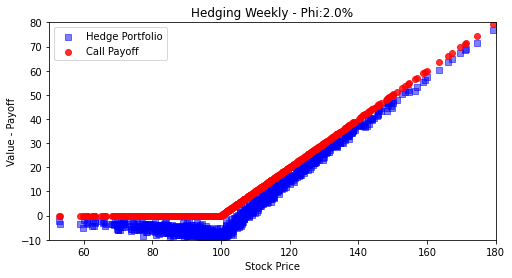

In [35]:
#Plotting the error the weekly rebalancing for three different transaction costs
#phi = 0.5%, 1%, and 2%
phi_list = [0.005, 0.01, 0.02]

for i in range(3):
    #Create the scatter plot
    fig,ax= plt.subplots(figsize=(8,4))
    ax.scatter(phi_d_df[i].stock_price, phi_d_df[i].Hedge_pf, marker="s", color="blue", label= "Hedge Portfolio", alpha=0.5)
    ax.scatter(phi_d_df[i].stock_price, phi_d_df[i].payoff, marker="o", color="red", label= "Call Payoff", alpha=0.8)

    #Set axis, title & legend
    ax.set_title("Hedging Weekly - Phi:"+str(phi_list[i]*100)+"%")
    ax.set_xlabel("Stock Price")
    ax.set_ylabel("Value - Payoff")
    ax.legend()

    #Set axis limit to see better that the transaction costs push the error down
    ax.set_xlim(50,180)
    ax.set_ylim(-10,80)
    

**Observation** - We see clearly above that the transaction costs pushes the error down, making it more negative. We see that the error is more important at the strike price.

To conclude, the transaction costs have a significant impact on the hedging error, especially if the hedge is being rebalanced frequently to maintain a certain level of protection.

### Q2-c Using Leland Adjustement
LeLand showed that one should account for the cost of hedging. Thus, he created an adjusted volatility formula that takes into account this cost of hedging. 
$$\sigma_{leland} = \sigma*(1+\sqrt{\frac{2*N}{\pi}}*\frac{\phi}{\sigma})^{1/2}$$

Looking at the formula we see that $\sigma_{leland} > \sigma$. Thus, we should expect a higher option price. One question remains: <br><br>
$$\textit{Is this adjustement enought to compensate the transaction cost impact?}$$

Let's analyse this:
1. Impact on stock price simulation. To do so, we will compute the difference between the stock price using the stock volatility and the Leland adjusted volatility.
2. Impact on the price of the call option usign the stock volatility and the Leland adjusted volatility.


In [36]:
###############################################
#LeLand Volatility for different value of Phi
###############################################

#List phi
phi_list = [0.005, 0.01, 0.02]
#List rebalancing
n_list = [12, 52, 252]
#def volatility
sigma = 0.2

#Define df
leland_df = pd.DataFrame(columns=["phi_05","phi_1", "phi_2"])

for n in n_list:
    #Compute adjusted Volatility
    leland_df.loc[len(leland_df)] = [sigma*(1+(((2*n)/np.pi)**0.5)*(phi/sigma))**0.5 for phi in phi_list]

#Set index
leland_df.index = ["monthly", "weekly", "daily"]

#Display
print("Table of the Leland Adjusted volatility")
leland_df.round(3)

Table of the Leland Adjusted volatility


phi_05  phi_1  phi_2
monthly   0.207  0.213  0.226
weekly    0.214  0.227  0.251
daily     0.229  0.256  0.301

In [37]:
#Recall the characteristics of the call option characteristics
stock_price = 100
strike = 100
interest_rate = 0.05
q=0 #dividend yield
n_years = 1.0
sigma = 0.2
mu = interest_rate 

#Weekly heding for test
n_steps = 52

In [38]:
###################################################
#Plotting the difference for different value of phi
# Weekly Hedging
###################################################
np.random.seed(123)
#Frequency
dt=1/n_steps

#Create a dataframe to store the data
error_df = pd.DataFrame()

#loop on phi
for i, sigma_leland in enumerate(leland_df.loc["weekly",:].values.tolist()):
    phi = phi_list[i]
    #Variable
    s_norm = 100
    s_leland =100
    norm_list=np.array([])
    leland_list=np.array([])
    
    #Loop on rebalancing
    for i in range(1,n_steps+1):
        Z = np.random.normal(loc=0.0, scale=1.0, size=1)
        #Black-Scholes
        s_norm = s_norm*exp((mu-q-(sigma**2)*0.5)*dt+sigma*Z*sqrt(dt))
        norm_list = np.append(norm_list, s_norm)
        
        #Leland
        s_leland = s_leland*exp((mu-q-(sigma_leland**2)*0.5)*dt+sigma_leland*Z*sqrt(dt))
        leland_list = np.append(leland_list, s_leland)
        
        #Compute the difference between BS and Leland
        error = norm_list - leland_list
        
    error_df[str(phi)] = error.tolist()

Text(0, 0.5, 'Difference in $')

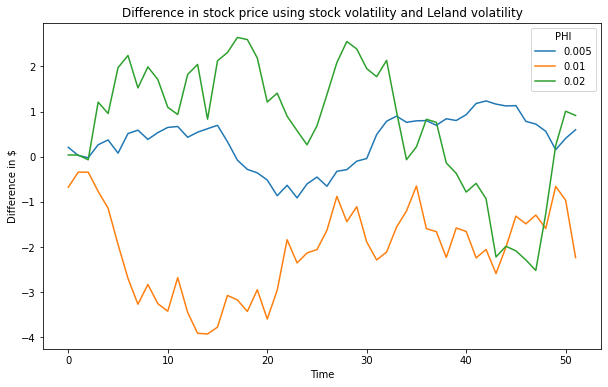

In [39]:
#Let's plot the data
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(error_df)

#Set legend, title, and axis
ax.legend(error_df.columns.values, title="PHI")
ax.set_title("Difference in stock price using stock volatility and Leland volatility")
ax.set_xlabel("Time")
ax.set_ylabel("Difference in $")

**Observation** - Due to the randomness we cannot identify any relevant information for the evolution of the stock price and the value of transaction cost.

In [40]:
#Recall the characteristics of the call option characteristics
stock_price = 100
strike = 100
interest_rate = 0.05
dividend_yield = 0 #dividend yield
n_years = 1.0
sigma = 0.2
mu = interest_rate 

#Data
valuation_date = Date(2, 12, 2022)
expiry_date = valuation_date.add_years(1)

#Define the call
call_option = EquityVanillaOption(expiry_date, strike, OptionTypes.EUROPEAN_CALL)

#Curve
discount_curve = DiscountCurveFlat(valuation_date, interest_rate)
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)

#Call option Price with BlackScholes
model = BlackScholes(sigma)
call_norm = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)

In [41]:
#Compute Call option value with the diff value of N and phi 
call_leland_df = pd.DataFrame(columns=["phi_05","phi_1", "phi_2"])

for k, n in enumerate([12, 52, 252]):
    list_call = []
    for i, phi in enumerate(phi_list):
        #Define the model with the new volatility
        model = BlackScholes(leland_df.iloc[k,i])
        call = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)
        list_call.append(call)
    #Append list
    call_leland_df.loc[len(call_leland_df)] = list_call

#Set index
call_leland_df.index = ["monthly", "weekly", "daily"]
    
#Display and rounding numbers
print("Value of Call adjusted for transaction cost with Leland")
call_leland_df.round(3)

Value of Call adjusted for transaction cost with Leland


phi_05   phi_1   phi_2
monthly  10.706  10.953  11.427
weekly   10.973  11.465  12.375
daily    11.561  12.548  14.273

In [42]:
#Display the pct difference with the value computed with BS
call_diff_pct_df=call_leland_df.apply(lambda x: 100*(x - call_norm)/call_norm)
#Display
print("Pct Difference between the value of a call using BS and Leland")
call_diff_pct_df.round(3)

Pct Difference between the value of a call using BS and Leland


phi_05   phi_1   phi_2
monthly   2.442   4.809   9.347
weekly    5.000   9.707  18.413
daily    10.623  20.070  36.578

**Observation**
- We see that the higher the transaction cost the higher the price of the call to compensate the trader when s/he will rebalance its portfolio.
- The price is also increasing with the rebalancing frequency. It makes sense because the more you rebalance the higher the total transaction costs of the hedging strategy. For the trader to break-even s/he will require a higher option price.

### Q3 -  Determining the implied density of the terminal stock price from the volatility skew.
#### Q3.a Build a Python function that extracts the market-implied distribution of S(T) at a 1-year horizon from σ(x) using the Breedon Litzenberg formula
The following 1-year volatility smile is given to us:
$$ \sigma(x) = a*x^2 + b*x + c $$
where:
- x is the moneyness (x = K/S(0))
- a = 0.025, b = -0.225, and c = 0.50
- S(0) = 100

With the volatility define above, we are able to price call option with different strikes using **FinancePy**. 

We know that there is a strong relationship between **option prices at different strikes** and the **underlying probability distribution g(S)**. Thus, Given a list of option prices for various strikes K, we can extract the 
market-implied probability distribution for the terminal stock price.
<br> Using the *Breedon Litzenberg* formula we have:
$$ g(K) = \frac{1}{Z(t,T)}*\frac{\partial^2V(t)}{\partial K^2}$$
In our function we will use the following approximation:
$$ g(K) = \frac{1}{Z(t,T)}*\frac{V(K+dK)-2*V(K)+V(K-dK)}{dK^2} $$ 

**How will we proceed in the function?**
1. Compute the volatility for different strikes
2. Compute the option prices for a given volatility, computed in 1, and a strike
3. From the price compute in 2 and the approximation of the Breedon Litzenberg formula with will compute the probability distribution

In [43]:
def density(stock_price, interest_rate, n_years, valuation_date):
    """
    Help - Variables
    strike: Option Strike
    n_years: number of years till maturity of the option
    valuation_date: Date at which we value the option
    Model use for the volatility: sigma_smile = a*x**2+b*x+c
    x  = strike/stock_price
    """
    #Expiry Date
    expiry_date = valuation_date.add_years(n_years)

    #Curve
    discount_curve = DiscountCurveFlat(valuation_date, interest_rate)
    dividend_curve = DiscountCurveFlat(valuation_date, 0)
        
    ############################################
    #1 & 2 - Compute volatility and option price
    ############################################
    #Value of the volatility model
    a=0.025
    b=-0.225
    c=0.5
        
    #Discount Factor
    z = exp(-interest_rate*n_years)

    #Dataframe to store the data
    call_df = pd.DataFrame(columns=["moneyness", "strike","volatility", "call_price"])
    
    #Loop on strike price
    for k in range(0,300):
        x=k/stock_price
        #Compute Volatility
        sigma_smile = a*x**2+b*x+c
        #Define the call with strike k
        call_option = EquityVanillaOption(expiry_date, k, OptionTypes.EUROPEAN_CALL)
        #Define model with new vol
        model = BlackScholes(sigma_smile)
        #Compute the call price
        call = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)
        #Put the data in the dataframe
        call_df.loc[len(call_df)] =[x, k, sigma_smile, call]
        
    ######################################
    #3- Compute Probability Distribution
    ######################################
    
    #loop here with dK=1
    dK=1
    #Store values
    g_list=[]
    for k in range(1,len(call_df.call_price)-1):
        g_k = (1/z)*((call_df.call_price[k+dK] - 2*call_df.call_price[k] + call_df.call_price[k-dK])/(dK**2))
        g_list.append(g_k)

    #Drop first and last row
    call_df.drop(call_df.tail(1).index,inplace=True)
    call_df.drop(call_df.head(1).index,inplace=True)
    #Append data in dataframe
    call_df["g"] = g_list
    
    #Return dataframe
    return call_df

In [44]:
#Run the function
call_df = density(100, 0.05, 1, valuation_date = Date(2, 12, 2022))

Text(0.5, 0, 'Moneyness')

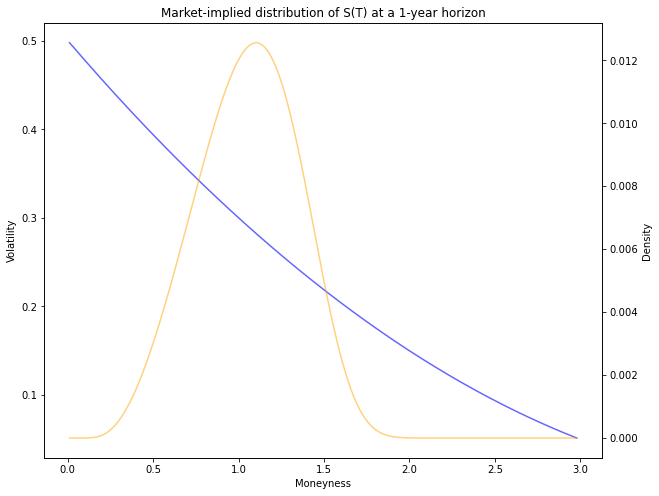

In [45]:
#Plot the volatility smile and the density
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(call_df.moneyness, call_df.volatility, label="Volatility", color="blue", alpha=0.6)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(call_df.moneyness, call_df.g, label="density", color="orange", alpha=0.5)

#Set Legend and title
ax.set_title("Market-implied distribution of S(T) at a 1-year horizon")
ax2.set_ylabel("Density")
ax.set_ylabel("Volatility")
ax.set_xlabel("Moneyness")


#### Q3.b - Digitial Call Option
We can write the value of European digital call option as:
$$ V(S(0),T) = e^{-r*T}*E[1_{S(T)>K}] $$
$$ \iff V(S(0),T) =e^{-r*T}*\int_{K}^{\infty} g(S) \, \mathrm{d}S $$
With the probability density funtion computer above we can price the digital call for different strikes. Let's do it for stikes of 60, 80, 100, 120 and 140$.

In [46]:
list_k = [ 60, 80, 100, 120, 140]
density_df = density(100, 0.05, 1, valuation_date = Date(2, 12, 2022))

#define dataframe to store the data
dig_price_df = pd.DataFrame(columns=["Strike", "Digital Option Probability"])

#Compute probabilities
for k in (list_k):
    #Sum probabilities for S>K
    dig_price_df.loc[len(dig_price_df)] = [k, density_df[density_df.strike>k].g.sum()]

#Discount Factor
z = exp(-0.05*1)

#Compute price
dig_price_df["Digital Option Price"] = dig_price_df["Digital Option Probability"].apply(lambda x: x*z)

In [47]:
#Display
dig_price_df

Strike  Digital Option Probability  Digital Option Price
0    60.0                    0.922610              0.877614
1    80.0                    0.784009              0.745773
2   100.0                    0.570419              0.542599
3   120.0                    0.322967              0.307216
4   140.0                    0.121285              0.115370

#### Q3.c - Black-Scholes pricing formula for digital call options
The Black-Scholes pricing formula for digital call options is the following:
$$ V(S(0),T) = e^{-r*T}*N(d_2) $$
where:
- r: risk free rate
- N: density probability function
- $d_2 = \frac{ln(S(0)/K+(r-\sigma^2/2)*T}{\sigma*\sqrt{T}}$

We are going to compute the price of the digital call option for K= 60, 80, 100, 120, and 140. <br>

We are going to compute the price of the digital call option using:
1. FinancePy
2. Formula from the lecture note


In [48]:
#1 - Using FinancePY
list_k = [ 60, 80, 100, 120, 140]

#Define digital call
valuation_date = Date(2, 12, 2022)
expiry_date = valuation_date.add_years(1)
discount_curve = DiscountCurveFlat(valuation_date, 0.05)
dividend_curve = DiscountCurveFlat(valuation_date, 0)
underlying_type = FinDigitalOptionTypes.CASH_OR_NOTHING

#To get the volatility for the model
density_df = density(100, 0.05, 1, valuation_date)
fpy_list=[]

for k in list_k:
    #Get volatility
    vol = density_df[density_df.strike==k].volatility.values[0]
    #define model
    model = BlackScholes(vol)
    #define digital call
    digitalCall = EquityDigitalOption(expiry_date, k, OptionTypes.EUROPEAN_CALL, underlying_type)
    #Compute value
    dig_val = digitalCall.value(valuation_date, 100, discount_curve, dividend_curve, model)
    fpy_list.append(dig_val)
    
dig_price_df["FinancePY"] =  fpy_list

In [49]:
#Display
dig_price_df

Strike  Digital Option Probability  Digital Option Price  FinancePY
0    60.0                    0.922610              0.877614   0.861176
1    80.0                    0.784009              0.745773   0.704398
2   100.0                    0.570419              0.542599   0.481939
3   120.0                    0.322967              0.307216   0.251315
4   140.0                    0.121285              0.115370   0.085536

In [50]:
#2 - Formula from lecture note
list_k = [ 60, 80, 100, 120, 140]
density_df = density(100, 0.05, 1, valuation_date)

#Variable
r, S_0, T = 0.05, 100, 1
#PV
z = exp(-0.05*1)

lecture_list=[]

for k in list_k:
    #Get volatility
    vol = density_df[density_df.strike==k].volatility
    #Compute d_2
    d_2 = (np.log(S_0/k)+(r-(vol**2)/2))/(vol*sqrt(T))
    #Normal distrib
    price = z*norm.cdf(d_2)
    lecture_list.append(price[0])

dig_price_df["Lecture Formula"] =  lecture_list

In [51]:
#Display
dig_price_df

Strike  Digital Option Probability  Digital Option Price  FinancePY  \
0    60.0                    0.922610              0.877614   0.861176   
1    80.0                    0.784009              0.745773   0.704398   
2   100.0                    0.570419              0.542599   0.481939   
3   120.0                    0.322967              0.307216   0.251315   
4   140.0                    0.121285              0.115370   0.085536   

   Lecture Formula  
0         0.861176  
1         0.704398  
2         0.481939  
3         0.251315  
4         0.085536

In [52]:
#Add a column for the percentage difference
dig_price_df["Pct diff Digital - FinancePy"] = 100*(dig_price_df.loc[:,"Digital Option Price"] - dig_price_df.loc[:,"FinancePY"])/dig_price_df.loc[:,"FinancePY"]
dig_price_df["Pct diff Digital - lecture formula"] = 100*(dig_price_df.loc[:,"Digital Option Price"] - dig_price_df.loc[:,"Lecture Formula"])/dig_price_df.loc[:,"Lecture Formula"]

In [53]:
#Display
print("Final Table ")
dig_price_df.round(4)

Final Table 


Strike  Digital Option Probability  Digital Option Price  FinancePY  \
0    60.0                      0.9226                0.8776     0.8612   
1    80.0                      0.7840                0.7458     0.7044   
2   100.0                      0.5704                0.5426     0.4819   
3   120.0                      0.3230                0.3072     0.2513   
4   140.0                      0.1213                0.1154     0.0855   

   Lecture Formula  Pct diff Digital - FinancePy  \
0           0.8612                        1.9087   
1           0.7044                        5.8738   
2           0.4819                       12.5866   
3           0.2513                       22.2434   
4           0.0855                       34.8791   

   Pct diff Digital - lecture formula  
0                              1.9087  
1                              5.8739  
2                             12.5866  
3                             22.2434  
4                             34.8792

**Observation** First, we can note that the price of the digital call option is the same using the Black-Scholes formula from the lecture note or FinancePY which is reassuring and makes sense.<br>
However, we see that we have a difference between the price computed in the *Question b and c*. Using the **probability density function** (PDF) doesn't result in the price as using the **Black-Shcoles pricing formula**. Indeed, using the PDF we obtain a higher price for the digital call option.
$$\textit{Why is there a difference?}$$

We know that accounting for the volatility smile shift the probability massdown, that's why we have higher probability thus higher prices. However, the price computed using FinancePy also account for the higher volatility. The difference can come from the fact that with the PDF we use discrete time instead of using the integral. <br>
All in all, as less assumptions are made in FinancePy and it uses an exact formula, the price should be more accurate with FinancePy.


#### Q3.e Calculate the value of a put option


$ \textbf{$1^{st}$ Method building a replicating portfolio} $ <br> <br>
We have a put option with strike 100 which only pays if the stock falls below 60 at expiry. What will the payoff look like ?
- 0, if S > 60 
- 40 + max(60 - S, 0), if S<60

This is equivalent to having **40 digital put option with a strike 60** and **one put option with strike 60**. Thus, we can price it using the FinancePy module.<br>

$\textbf{$2^{nd}$ Method using the density probability function}$<br> <br>
Is ther another way to price the option using the *PDF*? Yes, let's go back to the formula for a call option:
$$ V(S,T)=Z(0,T)*\int_{0}^{\infty} g(S)*max(K-S,0)\,dS=Z(0,T)*\int_{0}^{Barrier} g(S)*max(K-S,0)\,dS+ \int_{Barrier}^{\infty} g(S)*max(K-S,0)\,dS]  $$
In our case we know that the payoff will be null if the stock price is above 60 dollar (barrier price). So we can re-write the formule above.

$$ V(S,T) = Z(0,T)*\int_{0}^{Barrier} g(S)*max(K-S,0)\,dS $$

We know how to price an option with the formula above. Thus we can price it also using the density function we defined above. We will compare the result we get using the two techniques

In [54]:
def new_put_1(stock_price, strike_price, barrier_price, valuation_date, interest_rate, n_years):
    
    expiry_date = valuation_date.add_years(n_years)
    discount_curve = DiscountCurveFlat(valuation_date, interest_rate)
    dividend_curve = DiscountCurveFlat(valuation_date, 0)
    
    #Define volatility
    x = barrier_price/stock_price
    a, b, c = 0.025, -0.225, 0.5
    sigma_smile = a*x**2+b*x+c
    
    
    ##################
    #Digital Put price
    ##################
    #Define the model
    model = BlackScholes(sigma_smile)
    underlying_type = FinDigitalOptionTypes.CASH_OR_NOTHING
    digitalPut = EquityDigitalOption(expiry_date, barrier_price, OptionTypes.EUROPEAN_PUT, underlying_type)
    dig_price = digitalPut.value(valuation_date, stock_price, discount_curve, dividend_curve, model)
    
    ###########
    #Put price
    ###########
    #Define the model
    model = BlackScholes(sigma_smile)
    put_option = EquityVanillaOption(expiry_date, barrier_price, OptionTypes.EUROPEAN_PUT)
    put_price = put_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)
    
    #Price
    option_price = (strike_price-barrier_price)*dig_price+put_price
    
    return option_price

In [55]:
def new_put_2(stock_price, strike_price, barrier_price, valuation_date, interest_rate, n_years):
    
    new_put_df=pd.DataFrame(columns = ["stock_price", "probability", "payoff"])
    
    #pdf
    dens_df = density(stock_price, interest_rate, n_years, valuation_date)
    
    #filter on the stock price below the barrier
    for s in dens_df[dens_df.strike<barrier_price].strike:
        prob = dens_df[dens_df.strike==s].g.values[0]
        payoff = strike_price - s
        new_put_df.loc[len(new_put_df)] = [s, prob, payoff]
    
    #Sum product
    new_put_df["prob_times_payoff"] = new_put_df.probability*new_put_df.payoff
    
    put_price = new_put_df["prob_times_payoff"].sum()*exp(-interest_rate*n_years)
    
    return put_price

In [56]:
#Display
print("Price of the option using replicating option: %5.2f" %new_put_1(100, 100, 60, Date(2, 12, 2022), 0.05, 1))
print("Price of the option using the PDF: %5.2f" %new_put_2(100, 100, 60, Date(2, 12, 2022), 0.05, 1))

Price of the option using replicating option:  4.42
Price of the option using the PDF:  3.58


**Observation** We see that with the two methods we get two options prices that are different ($\approx$ 23%). As we saw above when pricing with a PDF or FinancyPy we have a difference that is also around (20% to 30%). The difference we get can be related to the error we get when when using the two method.

### Q.4 Modelling Volatility Skew
#### Q4.a CEV Monte Carlo
Constant elasticity model (CEV):
$$ \frac{dS}{S} = (r-q)*dt + \sigma_{CEV}*(\frac{S_t}{S_0})^\beta*dW_t \iff dS = (r-q)*S*dt + \sigma_{CEV}*S*(\frac{S_t}{S_0})^\beta*dW_t   $$ 

if we pose compare this to Black-Scholes we have:
$$ dS = (r-q)*S*dt + \sigma_{BS}*S*dW_t   $$ 

So, we have that :
$$ \sigma_{BS} = \sigma_{CEV}*(\frac{S_t}{S_0})^\beta$$

We can re-write the formula as:
$$ S(t+dt) = S(t) * [1+ (r-q)*dt + \sigma_{CEV}*(\frac{S_t}{S_0})^\beta*g*\sqrt{dt}] $$ 


where g is a Gaussian random number.

In the function below we will the fact that the **gaussian distribution is symetric**. The probability to have g is the same as the probability to have -g

In [57]:
def MC_cev(n_paths, stock_price, interest_rate, dividend_yield, volatility, beta, dt, n_years):
    #Steps for one path
    np.random.seed(1234)
    n_steps = int(n_years/dt)
    S_0 = stock_price
    
    #Dataframe store data
    stock_df = pd.DataFrame()
    
    #Loop on path
    for p in range(n_paths):
        #Variable to reset
        list_price_u = [S_0]
        list_price_d = [S_0]
        stock_price = S_0
        
        #Initialization
        dt_stock_price_u = stock_price
        dt_stock_price_d = stock_price
        
        #Loop on steps
        for t in range(1,n_steps+1):
            #Gaussian random number
            Z = np.random.normal(loc=0.0, scale=1.0, size=1)[0]
            
            #Antithetic method
            #Stock Price with +g
            sigma_cev = volatility*(dt_stock_price_u/S_0)**beta
            dt_stock_price_u = dt_stock_price_u*(1 + (interest_rate - dividend_yield)*dt + sigma_cev*Z*sqrt(dt))
            
            #Stok price with -g
            sigma_cev = volatility*(dt_stock_price_d/S_0)**beta
            dt_stock_price_d = dt_stock_price_d*(1+ (interest_rate - dividend_yield)*dt - sigma_cev*Z*sqrt(dt))

            #Append elements to list
            list_price_u.append(dt_stock_price_u)
            list_price_d.append(dt_stock_price_d)
            
        stock_df["price_p_g_"+str(p)] = list_price_u
        stock_df["price_m_g_"+str(p)] = list_price_d

    
    return stock_df

Text(0.5, 0, 'time steps')

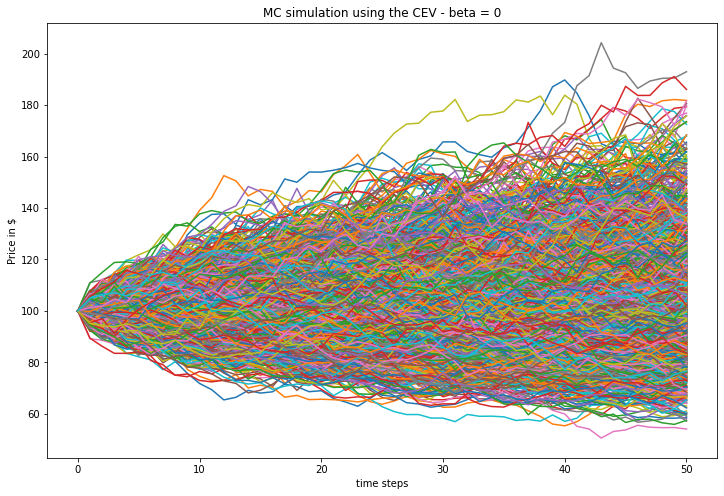

In [58]:
#Simulation for beta = 0 i.e BS model
sim_cev_beta_0 = MC_cev(n_paths=1000, stock_price=100, interest_rate=0.05, dividend_yield=0, volatility=0.2,
             beta=0, dt=0.02, n_years=1)
#Plot data
fig,ax= plt.subplots(figsize=(12,8))
ax.plot(sim_cev_beta_0)

ax.set_title("MC simulation using the CEV - beta = 0")
ax.set_ylabel("Price in $")
ax.set_xlabel("time steps")

Text(0.5, 0, 'time steps')

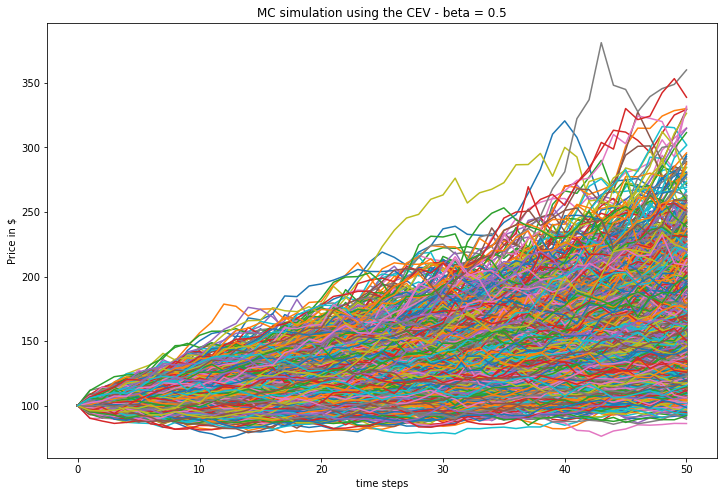

In [59]:
#Simulation for beta = 0.5
sim_cev_beta_05 = MC_cev(n_paths=1000, stock_price=100, interest_rate=0.5, dividend_yield=0, volatility=0.2,
             beta=0.5, dt=0.02, n_years=1)
#Plot data
fig,ax= plt.subplots(figsize=(12,8))
ax.plot(sim_cev_beta_05)

ax.set_title("MC simulation using the CEV - beta = 0.5")
ax.set_ylabel("Price in $")
ax.set_xlabel("time steps")

#### Q4-b Using the CEV model price a 6-month call option
First, let's build a function that can price a call option using the CEV model

In [60]:
def Call_cev(n_paths, stock_price, strike_price, interest_rate, dividend_yield, volatility, beta, dt, n_years):
    
    #Steps for one path
    np.random.seed(12)
    n_steps = int(n_years/dt)
    S_0 = stock_price
    list_payoff = []
    
    #Loop on path
    for p in range(n_paths):
         #Variable to reset
        list_price_u = [S_0]
        list_price_d = [S_0]
        stock_price = S_0
        
        #Init
        dt_stock_price_u = stock_price
        dt_stock_price_d = stock_price
        
        #Loop on steps
        for t in range(1,n_steps+1):
            #Gaussian random number
            Z = np.random.normal(loc=0.0, scale=1.0, size=1)[0]
            
            #Antithetic method
            #Stock Price with +g
            sigma_cev = volatility*(dt_stock_price_u/S_0)**beta
            dt_stock_price_u = dt_stock_price_u*(1 + (interest_rate - dividend_yield)*dt + sigma_cev*Z*sqrt(dt))
            
            #Stok price with -g
            sigma_cev = volatility*(dt_stock_price_d/S_0)**beta
            dt_stock_price_d = dt_stock_price_d*(1+ (interest_rate - dividend_yield)*dt - sigma_cev*Z*sqrt(dt))
        
        #Compute last payoff
        call_payoff_u = max(dt_stock_price_u-strike_price,0)
        call_payoff_d = max(dt_stock_price_d-strike_price,0)
        
        list_payoff.append(call_payoff_u)
        list_payoff.append(call_payoff_d)

        
    #Compute call value
    call_value = np.mean(list_payoff)*exp(-interest_rate*n_years)
    
    return call_value

To check our model we will price an option for beta = 0 with the function defined above and compare it with the price of an option priced using FinancePy, which represents the Black-Scholes model.

In [61]:
#Let's do a simple test to see the accuracy of our MC modelization
call_price = Call_cev(n_paths=10000, stock_price=100, strike_price=100, interest_rate=0.05,
                     dividend_yield=0, volatility=0.2, beta=0, dt=0.02, n_years=0.5)

In [62]:
#Check the price with FinancePy
valuation_date = Date(2, 12, 2022)
expiry_date = valuation_date.add_years(0.5)
stock_price = 100
strike_price = 100
volatility = 0.20
interest_rate = 0.05
dividend_yield = 0.0
call_option = EquityVanillaOption(expiry_date, strike_price, OptionTypes.EUROPEAN_CALL)
discount_curve = DiscountCurveFlat(valuation_date, interest_rate)
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)
model = BlackScholes(volatility)

call_value = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)

In [63]:
#Display
print("-------------------------------------------")
print("Checking our Model")
print("-------------------------------------------")
print("Call price using CEV:", round(call_price,4))
print("Call price using FinancePy:",round(call_value,4))
print("-------------------------------------------")
print("Pricing error in pct:", round(100*(call_value-call_price)/call_value,3),"%")

-------------------------------------------
Checking our Model
-------------------------------------------
Call price using CEV: 6.8718
Call price using FinancePy: 6.8776
-------------------------------------------
Pricing error in pct: 0.084 %


**Observation** - Our model seems to be correct, the error is in the order of $10^{-4}$.

Let's price the call option for:
- For different strike from 80 to 120 in steps of 5 dollars.
- For different value of $\beta$ = -0.5, -0.25, 0, 0.25, 0.5

In [64]:
#Define the list of betas
beta_list=[-0.5, -0.25, 0, 0.25, 0.5]

#Create the dataframe
cev_df = pd.DataFrame(columns=["strike","beta_m_0.5", "beta_m_0.25", "beta_0", "beta_0.25", "beta_0.5", "BS_beta_0"])

#Loop on the strike
for k in range(80,121,5):
    list_price=[k]
    #Loop on betas
    for b in beta_list:
        #Compute option prices
        call_value = Call_cev(n_paths=10000, stock_price=100, strike_price=k, interest_rate=0.05,
                         dividend_yield=0, volatility=0.2, beta=b, dt=0.02, n_years=0.5)
        list_price.append(call_value)
    
    #Check the price with FinancePy for beta = 0
    valuation_date = Date(2, 12, 2022)
    expiry_date = valuation_date.add_years(0.5)
    stock_price = 100
    volatility = 0.20
    interest_rate = 0.05
    dividend_yield = 0
    call_option = EquityVanillaOption(expiry_date, k, OptionTypes.EUROPEAN_CALL)
    discount_curve = DiscountCurveFlat(valuation_date, interest_rate)
    dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)
    model = BlackScholes(volatility)

    #Put in df
    call_value = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)
    list_price.append(call_value)
    
    cev_df.loc[len(cev_df)] = list_price

In [65]:
#Display dataframe
cev_df.round(4)

strike  beta_m_0.5  beta_m_0.25   beta_0  beta_0.25  beta_0.5  BS_beta_0
0    80.0     22.2252      22.1906  22.1591    22.1303   22.1042    22.1680
1    85.0     17.7141      17.6684  17.6250    17.5836   17.5442    17.6443
2    90.0     13.5651      13.5188  13.4737    13.4297   13.3868    13.4890
3    95.0      9.9132       9.8828   9.8531     9.8240    9.7958     9.8620
4   100.0      6.8738       6.8724   6.8718     6.8720    6.8728     6.8776
5   105.0      4.4947       4.5253   4.5570     4.5897    4.6234     4.5711
6   110.0      2.7581       2.8143   2.8716     2.9303    2.9906     2.8973
7   115.0      1.5805       1.6480   1.7176     1.7897    1.8643     1.7543
8   120.0      0.8409       0.9056   0.9739     1.0458    1.1216     1.0172

#### Q4.c Convert the prices calculated in (b) to implied volatilities to show the model-implied skew

In [66]:
#Define Inputs
stock_price = 100
valuation_date = Date(2, 12, 2022)
expiry_date = valuation_date.add_years(0.5)
discount_curve = DiscountCurveFlat(valuation_date, 0.05)
dividend_curve = DiscountCurveFlat(valuation_date, 0)

#Copy df
impl_vol_df = pd.DataFrame(columns=["strike","beta_m_0.5", "beta_m_0.25", "beta_0", "beta_0.25", "beta_0.5", "BS_beta_0"])

for k in cev_df.strike:
    list_vol = [k]
    for v in cev_df[cev_df.strike==k].values[0][1:]:
        call_option = EquityVanillaOption(expiry_date, k, OptionTypes.EUROPEAN_CALL)
        sigma = call_option.implied_volatility(valuation_date, stock_price, discount_curve, dividend_curve, v)
        list_vol.append(sigma)
    impl_vol_df.loc[len(impl_vol_df)] = list_vol

#Change index for the moneyness
impl_vol_df.strike = impl_vol_df.strike / stock_price
impl_vol_df.set_index("strike", inplace=True)

In [67]:
#Display
impl_vol_df

beta_m_0.5  beta_m_0.25    beta_0  beta_0.25  beta_0.5  BS_beta_0
strike                                                                   
0.80      0.210011     0.204131  0.198295   0.192466  0.186593        0.2
0.85      0.206401     0.202252  0.198160   0.194117  0.190116        0.2
0.90      0.204383     0.201729  0.199110   0.196527  0.193981        0.2
0.95      0.202186     0.200886  0.199617   0.198374  0.197163        0.2
1.00      0.199861     0.199810  0.199788   0.199796  0.199824        0.2
1.05      0.197274     0.198367  0.199497   0.200664  0.201863        0.2
1.10      0.194568     0.196763  0.198999   0.201283  0.203619        0.2
1.15      0.191759     0.194986  0.198282   0.201651  0.205105        0.2
1.20      0.188810     0.193018  0.197327   0.201743  0.206275        0.2

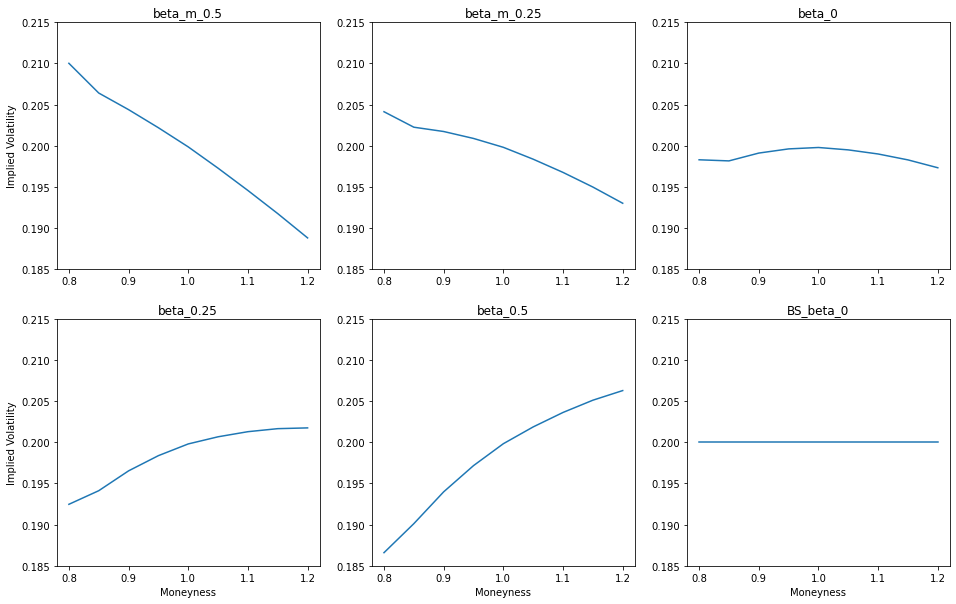

In [68]:
fig, ax = plt.subplots(2,3,figsize=(16,10))
count = 0
for i in range(2):
    for j in range(3):
        ax[i,j].plot(impl_vol_df[impl_vol_df.columns[count]])
        #Title, legend
        ax[i,j].set_title(str(impl_vol_df.columns[count]))
        if j == 0:
            ax[i,j].set_ylabel("Implied Volatility")
        if i == 1:
            ax[i,j].set_xlabel("Moneyness")
        #Limit
        ax[i,j].set_ylim(0.185, 0.215)


        count+=1

**Observation** - 
- **Beta = 0**: We see that we almost have an horizontal line close to 0.2 as we should have if we used the BS model. This is indicates that we build a right model for the CEV above.
$$ \sigma_{BS} = \sigma_{CEV}*(\frac{S_t}{S_0})^\beta$$
- **Beta < 0**: From the formula above we should expect the volatility to decrease when the stock price increases that's what we have in the graphs above.
- **Beta > 0**: On the contrary, in this case for beta postive the volatility should increase as the price increases according to the formula. Once again we have the expected results in the graph above.

We can also notice that the curve is steeper with higher value onf Beta either positive or negative value.

#### Q4.d Option Delta in the CEV model
We are going to compute the option delta by bumping the input stock price by 0.1 and recalculating the option price. We know that:
$$  \Delta = \frac{\partial V}{\partial S} $$
So in our case we will have 
$$  \Delta = \frac{V_{bumped} - V_{initial}}{0.1} $$


In [69]:
#Define the list of betas
beta_list=[-0.5, -0.25, 0, 0.25, 0.5]

#Create the dataframe
cev_bump_df = pd.DataFrame(columns=["strike","beta_m_0.5", "beta_m_0.25", "beta_0", "beta_0.25", "beta_0.5", "BS_beta_0"])

#Price bumped by 0.1
stock_price_bump = stock_price + 0.1

#Loop on the strike
for k in range(80,121,5):
    list_price=[k]
    #Loop on betas
    for b in beta_list:
        #Compute option prices
        call_value = Call_cev(n_paths=10000, stock_price=stock_price_bump, strike_price=k, interest_rate=0.05,
                         dividend_yield=0, volatility=0.2, beta=b, dt=0.02, n_years=0.5)
        list_price.append(call_value)
    
    #Check the price with FinancePy for beta = 0
    valuation_date = Date(2, 12, 2022)
    expiry_date = valuation_date.add_years(0.5)
    stock_price = stock_price_bump
    volatility = 0.20
    interest_rate = 0.05
    dividend_yield = 0
    call_option = EquityVanillaOption(expiry_date, k, OptionTypes.EUROPEAN_CALL)
    discount_curve = DiscountCurveFlat(valuation_date, interest_rate)
    dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)
    model = BlackScholes(volatility)

    #Put in df
    call_value = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)
    list_price.append(call_value)

    cev_bump_df.loc[len(cev_bump_df)] = list_price


In [70]:
#Compute delta
delta_df = (cev_bump_df - cev_df)/0.1
#Set new index
delta_df.strike = cev_bump_df.strike
delta_df.set_index("strike", inplace=True)
#Display
delta_df

beta_m_0.5  beta_m_0.25    beta_0  beta_0.25  beta_0.5  BS_beta_0
strike                                                                   
80.0      0.963545     0.965477  0.967553   0.969417  0.971394   0.966428
85.0      0.918859     0.920052  0.921175   0.922285  0.923452   0.919461
90.0      0.843481     0.841712  0.840276   0.838817  0.837269   0.840549
95.0      0.738488     0.733669  0.728791   0.724105  0.719471   0.730352
100.0     0.612559     0.605398  0.598874   0.592133  0.586503   0.598974
105.0     0.476327     0.469924  0.463013   0.457433  0.451599   0.462243
110.0     0.344647     0.341062  0.337660   0.334269  0.331022   0.335717
115.0     0.231695     0.231786  0.231200   0.230669  0.229444   0.229976
120.0     0.142832     0.145966  0.148669   0.150743  0.152599   0.149102

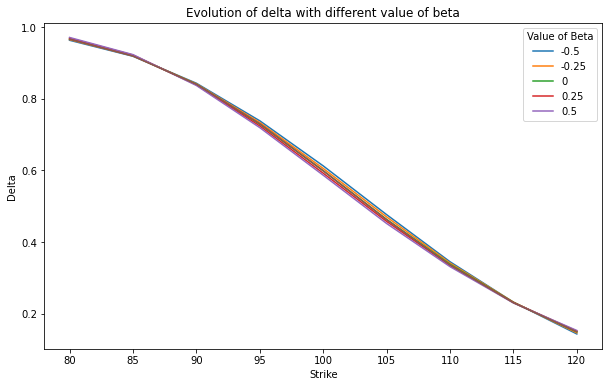

In [71]:
#Plot the delta
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(delta_df)

ax.set_title("Evolution of delta with different value of beta")
ax.set_xlabel("Strike")
ax.set_ylabel("Delta")
ax.legend(beta_list)
ax.get_legend().set_title("Value of Beta")

**Observation**
- First, as expected the delta of the call is between 0 and 1. The curve is also right because here the stock price is fixed and the strike moves. So the lower the stock price (<100) the more the option is ITM, so the closer delta will be to one. The higher the strike (>100) the more the option is OTM, so the closer the delta will be to zero.

<font color='red'> /!\ With the graph we plotted above it's hard to compare the value of delta for different betas. We are going to plot the delta for each strike to see if a difference appears.</font>

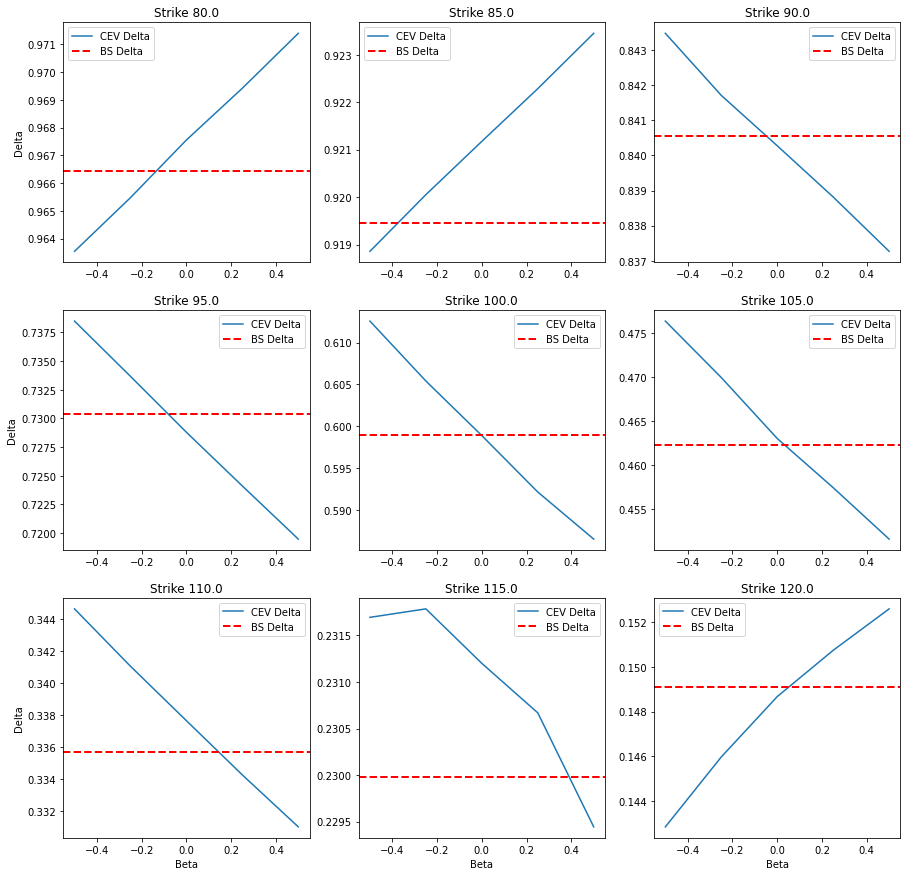

In [72]:
#Plot the delta
beta_list=[-0.5, -0.25, 0, 0.25, 0.5]
fig, ax = plt.subplots(3, 3, figsize=(15,15))
i, j = 0, 0
for k in delta_df.index:
    #Delta of all betas for the same strike
    list_delta = delta_df[delta_df.index==k].values[0].tolist()
    ax[i,j].plot(beta_list, list_delta[:-1], label="CEV Delta")
    ax[i,j].axhline(y=list_delta[-1:][0], color='r', linestyle='dashed', linewidth=2, label="BS Delta")    
    if i == 2:
        ax[i,j].set_xlabel("Beta")
    ax[i,j].set_title("Strike "+str(k))
    if j==0:
        ax[i,j].set_ylabel("Delta")
    
    ax[i,j].legend()
    if j == 2:
        j=0
        i+=1
    else:
        j+=1

        

**Observation** For far ITM and OTM (strikes 80, 90 and 120), delta is increasing with beta. Else, delta decreases with beta.
<br>For far ITM and OTM options, the delta of the option will increase with beta because a higher value of beta means that the underlying asset's volatility increases more quickly as the asset's price increases. This means that the option's price is more sensitive to changes in the underlying asset's price, and the delta will be higher.

### Q5 Variance Swaps

#### Q5.a Dynamic hedging of a 1 year Variance swap with daily hedging
If the stock price is continuously samples the realized variance can be written as:
$$ V = \frac{2}{T}*[\int_{0}^{T}\frac{\,dS(t)}{S(t)} - ln(\frac{S(T)}{S(0)})] $$
We have two part for the replicating strategy:
- **Dynamic part**, which consist in change in value of 2/T times 1/S(T) shares in the stock summed over every time interval from start time to time T.
- **Static part**, whih consists of a log contract

The realized variance is:
$$ \sigma^2  = \frac{252}{T}\sum_{i=1}^{T} [ln(\frac{S_i}{S_{i-1}})]^2$$

In [73]:
def var_hedge(m_years, stock_price, volatility, growth_rate):
    
    ####################################
    #Simulation of stock price evolution
    ####################################
    
    #Daily hedging 
    dt = 1/252
    #List to store stock prices
    list_stock = [stock_price]
    n_stock_price = stock_price
    
    #Stock price evolution
    for i in range(m_years*252):
        #Random Number
        Z = np.random.normal(loc=0.0, scale=1.0, size=1)[0]
        #Exact formula
        n_stock_price = list_stock[-1] * exp((growth_rate-(volatility**2)*0.5)* dt 
                                                   + volatility * Z * dt**0.5)
        list_stock.append(n_stock_price)
    
    stock_df = pd.DataFrame({"stock_price":list_stock})
    
    #################################
    #Dynamic Part
    #################################
    stock_df["pct_chg"] = stock_df.pct_change()
    dynamic_value = stock_df["pct_chg"].sum()
    
    #################################
    #Static Part
    #################################
    static_value = np.log(stock_df.stock_price.iloc[-1:].values[0]/stock_price)
    
    #Combine everything
    
    V_h = (2/(m_years))*(dynamic_value-static_value)
    
    #################################
    #Realized Variance
    #################################
    stock_df["realized"] = (stock_df.stock_price / stock_df.stock_price.shift(1)).apply(np.log)
    V_r = (stock_df["realized"].pow(2)).sum()
    
    return V_h, V_r

In [74]:
#Let's do a test
a=var_hedge(1, 100, 0.3, 0.05)
print("---"*4)
print("Variance with the edging portfolio: %5.2f"%a[0])
print("Realized Variance: %5.2f"%a[1])
print("---"*4)
print("Error in pct: %5.2f"% (100*((a[0]-a[1])/a[1])))
print("---"*4)

------------
Variance with the edging portfolio:  0.10
Realized Variance:  0.10
------------
Error in pct:  0.13
------------


**Observation** - The portfolio constructed replicates well the variance of the market, thus we are well hedge with this portfolio if we sell a variance swap.

#### Q5.b  compute a histogram of the final P&L of a variance swap that has been hedged dynamically
What is the payoff of a variance swap ?
$$ payoff = (\sigma_{strike}^2 - \sigma_{realized}^2)*Notional $$
The P&L will be largely impacted by how well we can replicate the realized variance with our portfolio

In [75]:
V_strike = 0.3**2
pnl_df = pd.DataFrame(columns=["V_realized","PnL"])
for p in range(1000):
    V_h, V_r=var_hedge(1, 100, 0.3, 0.05)
    pnl = V_strike - (V_r-V_h)
    pnl_df.loc[len(pnl_df)] = [V_r, pnl]

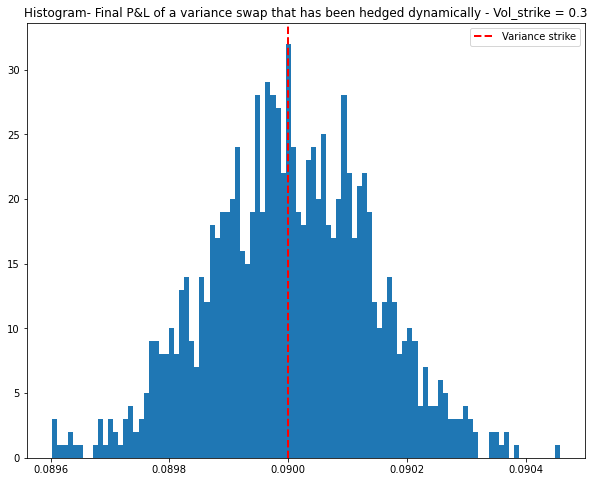

In [76]:
#Plot histogram
fig, ax = plt.subplots(figsize=(10,8))

ax.hist(pnl_df.PnL, bins=100)
#Vertical line to situate the variance strike
ax.axvline(x=V_strike, color='r', linestyle='dashed', linewidth=2, label="Variance strike")

ax.legend()
ax.set_title("Histogram- Final P&L of a variance swap that has been hedged dynamically - Vol_strike = 0.3");

**Observation** - As we can see most of the final P&L are concentrated around the volality strike of the contract.

### Q.6 Swap & Swaption Pricing
#### Q.6.a Reproduce excel swap pricing grid sheet

In [77]:
def swap_grid(rates_list, year, month, day):
    
    ##################################
    #1- Dates and day count convention
    ##################################
    
    #Different payments Date, and we calculate the year fractions between 2 dates
    dates_list = []
    diff_year_list =  []
    start_date = datetime.datetime(year, month, day) 

    #Loop on the date define
    for i in range(20):
        #Define the new end data
        end_date = start_date + relativedelta(months = 6)
        #Day count convention
        date_diff  = end_date - start_date
        difference_in_years = date_diff.days/365
        start_date=end_date

        #Append elements
        dates_list.append(end_date.strftime("%d-%b-%y"))
        diff_year_list.append(difference_in_years)
        
    ###########################################
    #2- Interpolation to find the missing rates
    ###########################################
    #we interpolate to find the list of 20 rates
    interpolate_df = pd.DataFrame(columns=["Swap_rates"],index=np.linspace(0.5,10,20))

    #Suppose that the 6M swap rate is equal to the one year
    interpolate_df.iloc[0]=rates_list[0]
    #Input the rate we know i.e 1, 2, 3, 5, 7 and 10 years
    interpolate_df.iloc[1]=rates_list[0]
    interpolate_df.iloc[3]=rates_list[1]
    interpolate_df.iloc[5]=rates_list[2]
    interpolate_df.iloc[9]=rates_list[3]
    interpolate_df.iloc[13]=rates_list[4]
    interpolate_df.iloc[19]=rates_list[5]

    #Interpolate until 7 years
    interpolate_df.iloc[2]=(interpolate_df.iloc[3] + interpolate_df.iloc[1])/2
    interpolate_df.iloc[4]=(interpolate_df.iloc[5] + interpolate_df.iloc[3])/2
    interpolate_df.iloc[7]=(interpolate_df.iloc[9] + interpolate_df.iloc[5])/2
    interpolate_df.iloc[6]=(interpolate_df.iloc[7]+interpolate_df.iloc[5])/2
    interpolate_df.iloc[8]=(interpolate_df.iloc[9]+interpolate_df.iloc[7])/2
    interpolate_df.iloc[11]=(interpolate_df.iloc[13]+interpolate_df.iloc[9])/2
    interpolate_df.iloc[10]=(interpolate_df.iloc[11]+interpolate_df.iloc[9])/2
    interpolate_df.iloc[12]=(interpolate_df.iloc[13]+interpolate_df.iloc[11])/2

    #Interpolate from 7.5 years to 9.5 years
    last=np.linspace(interpolate_df.iloc[13],interpolate_df.iloc[19],7)
    interpolate_df.iloc[14]=last[1]
    interpolate_df.iloc[15]=last[2]
    interpolate_df.iloc[16]=last[3]
    interpolate_df.iloc[17]=last[4]
    interpolate_df.iloc[18]=last[5]

    #Reset index and set 1st column as term
    interpolate_df.reset_index(inplace=True)
    interpolate_df.columns = ["term", "swap_rate"]
    
    ################################################
    #3- Create the dataframe to match the excel file
    ################################################
    #First row will be the year fraction
    columns = ["term", "swap_rate"] + dates_list 
    payoff_df = pd.DataFrame(columns = columns)

    #Add year diff as a row
    payoff_df.loc[len(payoff_df)] = [np.nan, np.nan] + diff_year_list
    payoff_df.index = ["years_list"]

    #Add blank rows
    for i in range(len(interpolate_df)):
        payoff_df.loc[len(payoff_df)] = [0]*len(payoff_df.columns)

    #Add term and swap_rate columns
    payoff_df["term"] = ["years_list"] + interpolate_df.term.tolist()
    payoff_df["swap_rate"] = [np.nan] + interpolate_df.swap_rate.tolist()

    #Set term as index
    payoff_df.set_index("term", inplace = True)
    
    ########################
    #4- Fill in the payments
    ########################
    for i in range(1,payoff_df.shape[0]):
        payoff_df.iloc[i,i]=1
        for j in range(1,i+1):
            payoff_df.iloc[i,j]=payoff_df.iloc[i,j]+payoff_df.iloc[i,0]*payoff_df.iloc[0,j]
        
    ############################
    #5- Compute Discount Factors
    ############################
    #Inverse the matrix
    sub_df=payoff_df.iloc[1:,1:]
    matrix_S=sub_df.to_numpy(np.float64)
    matrix_S_inverse=np.linalg.inv(matrix_S)
    #Define the unit vector
    vect_unit=np.ones((matrix_S.shape[0],), dtype=float)
    #Matric product
    discount_factors=np.dot(matrix_S_inverse,vect_unit)

    #Add to the Dataframe
    payoff_df["z_factor"] = [np.nan] + discount_factors.tolist()
    
    return (payoff_df)

In [78]:
#Assume Flat Swap rate at 5%
rates_list = [0.05,0.05,0.05,0.05,0.05,0.05]
year, month, day = 2017, 12, 7
swap_grid_df = swap_grid(rates_list, year, month, day)

In [79]:
#Display 
swap_grid_df.head(5)

swap_rate  07-Jun-18  07-Dec-18  07-Jun-19  07-Dec-19  07-Jun-20  \
term                                                                           
years_list        NaN   0.498630   0.501370   0.498630   0.501370    0.50137   
0.5              0.05   1.024932   0.000000   0.000000   0.000000    0.00000   
1.0              0.05   0.024932   1.025068   0.000000   0.000000    0.00000   
1.5              0.05   0.024932   0.025068   1.024932   0.000000    0.00000   
2.0              0.05   0.024932   0.025068   0.024932   1.025068    0.00000   

            07-Dec-20  07-Jun-21  07-Dec-21  07-Jun-22  ...  07-Dec-23  \
term                                                    ...              
years_list    0.50137    0.49863    0.50137    0.49863  ...    0.50137   
0.5           0.00000    0.00000    0.00000    0.00000  ...    0.00000   
1.0           0.00000    0.00000    0.00000    0.00000  ...    0.00000   
1.5           0.00000    0.00000    0.00000    0.00000  ...    0.00000   
2.0           0.00000    0.00000    0.00000    0.00000  ...    0.00000   

            07-Jun-24  07-Dec-24  07-Jun-25  07-Dec-25  07-Jun-26  07-Dec-26  \
term                                                                           
years_list    0.50137    0.50137    0.49863    0.50137    0.49863    0.50137   
0.5           0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
1.0           0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
1.5           0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
2.0           0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   

            07-Jun-27  07-Dec-27  z_factor  
term                                        
years_list    0.49863    0.50137       NaN  
0.5           0.00000    0.00000  0.975675  
1.0           0.00000    0.00000  0.951814  
1.5           0.00000    0.00000  0.928661  
2.0           0.00000    0.00000  0.905951  

[5 rows x 22 columns]

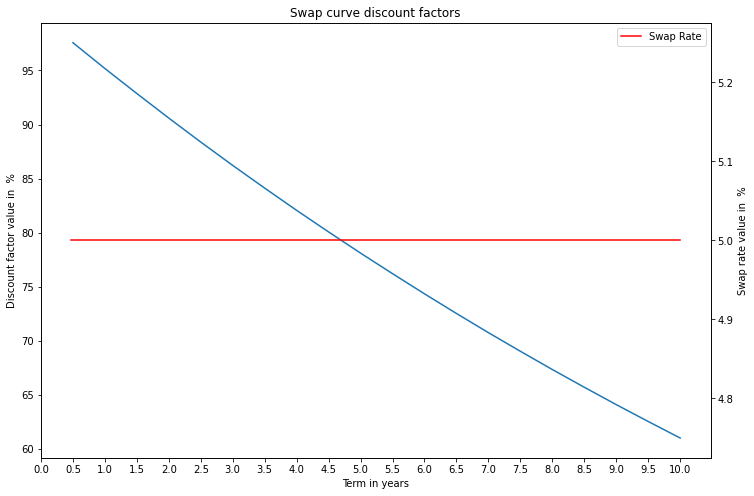

In [80]:
#Swap Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(swap_grid_df.index[1:], swap_grid_df.z_factor[1:]*100, label= "Discount Factors")
#Plot flat swap rate
ax2 = ax.twinx()
ax2.plot(swap_grid_df.index[1:], swap_grid_df.swap_rate[1:]*100, label= "Swap Rate", color="red")

#Title
plt.title("Swap curve discount factors")

#Axis
ax.set_xticks(np.arange(0,10.5,0.5))
ax.set_ylabel("Discount factor value in  %")
ax2.set_ylabel("Swap rate value in  %")
ax.set_xlabel("Term in years")
ax2.legend(loc=0);

#### Q6.b Build a swap curve 
**Inputs**
- Date : December 7 2017
- Rates: 1Y 2.3% 2Y 2.6% 3Y 2.86% 5Y 3.03% 7Y 3.18% 10Y 3.25%

In [81]:
#Call the function define above
rates_list = [0.023,0.026,0.0286,0.0303,0.0318,0.0325]
year, month, day = 2017, 12, 7
swap_grid_df = swap_grid(rates_list, year, month, day)

In [82]:
#Display 
swap_grid_df.head(5)

swap_rate  07-Jun-18  07-Dec-18  07-Jun-19  07-Dec-19  07-Jun-20  \
term                                                                           
years_list        NaN   0.498630   0.501370   0.498630   0.501370    0.50137   
0.5            0.0230   1.011468   0.000000   0.000000   0.000000    0.00000   
1.0            0.0230   0.011468   1.011532   0.000000   0.000000    0.00000   
1.5            0.0245   0.012216   0.012284   1.012216   0.000000    0.00000   
2.0            0.0260   0.012964   0.013036   0.012964   1.013036    0.00000   

            07-Dec-20  07-Jun-21  07-Dec-21  07-Jun-22  ...  07-Dec-23  \
term                                                    ...              
years_list    0.50137    0.49863    0.50137    0.49863  ...    0.50137   
0.5           0.00000    0.00000    0.00000    0.00000  ...    0.00000   
1.0           0.00000    0.00000    0.00000    0.00000  ...    0.00000   
1.5           0.00000    0.00000    0.00000    0.00000  ...    0.00000   
2.0           0.00000    0.00000    0.00000    0.00000  ...    0.00000   

            07-Jun-24  07-Dec-24  07-Jun-25  07-Dec-25  07-Jun-26  07-Dec-26  \
term                                                                           
years_list    0.50137    0.50137    0.49863    0.50137    0.49863    0.50137   
0.5           0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
1.0           0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
1.5           0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
2.0           0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   

            07-Jun-27  07-Dec-27  z_factor  
term                                        
years_list    0.49863    0.50137       NaN  
0.5           0.00000    0.00000  0.988662  
1.0           0.00000    0.00000  0.977391  
1.5           0.00000    0.00000  0.964138  
2.0           0.00000    0.00000  0.949564  

[5 rows x 22 columns]

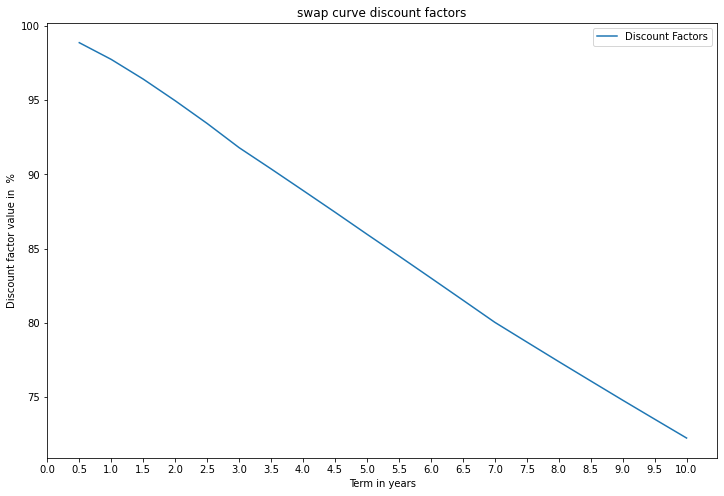

In [83]:
#Swap Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(swap_grid_df.index[1:], swap_grid_df.z_factor[1:]*100, label= "Discount Factors")
#Title
plt.title("swap curve discount factors")
#Axis
ax.set_xticks(np.arange(0,10.5,0.5))
ax.set_ylabel("Discount factor value in  %")
ax.set_xlabel("Term in years")
ax.legend();

**Verify the 0 value upfront:**<br>
In order to do this, we will discount the fixed leg cashflows of the different swaps with the factors we just found.
We know that the floating leg value is 1.

In [84]:
#We extract the cashflows series from the previous dataframe, and we create two lists corresponding to the maturities 
#and swap rates
discount=swap_grid_df.z_factor[1:]
rates_list = [0.023,0.026,0.0286,0.0303,0.0318,0.0325]
maturity=[1,2,3,5,7,10]
fixed_leg_repricing=pd.DataFrame(columns=['fixed_leg_value'])

In [85]:
#the value of the fixed leg is the sum of the product of the cashflows and discount factors

for i in range(len(maturity)):
    cashflows=1000000*180/360*rates_list[i]*np.ones(2*maturity[i])
    cashflows[-1]=cashflows[-1]+1000000
    discount_factors=discount[:maturity[i]*2].to_numpy()
    fix_value=np.dot(cashflows,discount_factors)

#we proceed to a rescaling by dividing the value of the fixed leg by the notional N=1000000€    
    
    print("Value of the "+ str(maturity[i]) +" year swap upfront:",fix_value/1000000)


Value of the 1 year swap upfront: 1.0000003551070245
Value of the 2 year swap upfront: 1.0000009204918952
Value of the 3 year swap upfront: 0.9999284462675337
Value of the 5 year swap upfront: 0.9999254126965123
Value of the 7 year swap upfront: 0.9998519880761285
Value of the 10 year swap upfront: 0.999850461716719


**Conclusion:** we find the fixed legs equal to 1 (with some error margin).
The value of the swap is the value of the fixed leg minus the floating one, so the value of each swap is 0 upfront.

#### Q6.c Forward rate for a 1x7 year swap with semi-annual fixed leg payments
Forward rate make the value of the swaptions equal to zero today. F has the following formula
$$ F = \frac{Z(0,T) - Z(0,t_N)}{\sum_{i=1}^{N}\Delta_i*Z(0,t_i)} = \frac{Z(0,T) - Z(0,t_N)}{A(0,T,t_N)} $$

We have a 1x7 years swap i.e
- 1 year until the maturity of the option: T = 1 years
- The underlying is a swap with maturity 7 years: $t_N$= 8 years

We can price this using the function defined above

In [86]:
#Call the function define above
rates_list = [0.023,0.026,0.0286,0.0303,0.0318,0.0325]
year, month, day = 2017, 12, 7
swap_grid_df = swap_grid(rates_list, year, month, day)

In [87]:
z_t1 = swap_grid_df[swap_grid_df.index == 1].z_factor.values[0]
z_t2 = swap_grid_df[swap_grid_df.index == 8].z_factor.values[0]

#Let's compute the PV01
delta = swap_grid_df.iloc[0,:][1:-1].values
z_factor = swap_grid_df.z_factor[1:].values
PV01 = np.dot(delta, z_factor)

#Forward rate
F = (z_t1 - z_t2)/PV01

print("----"*5)
print("Z(T1) = %5.4f"%z_t1)
print("Z(T2) = %5.4f"%z_t2)
print("----"*5)
print("PV01 = %5.4f"%PV01)
print("----"*5)
print("The forward rate is equal to %6.4f"%F)

--------------------
Z(T1) = 0.9774
Z(T2) = 0.7738
--------------------
PV01 = 8.5429
--------------------
The forward rate is equal to 0.0238


#### Q6.d Black’s model, value a 1x7 Payer and a 1x7 Receiver swaption with a strike 2.15%.
$$ V_{payer} = A(0,T,t_N) * [F_0*\phi(d_1) - K*\phi(d_2)] $$
$$ V_{receiver} = A(0,T,t_N) * [K*\phi(-d_2) - F_0*\phi(-d_1)] $$

with:
- $ d_1 = \frac{ln(\frac{F}{K})+\frac{T*\sigma^2}{2}}{\sigma * \sqrt{T}} $
- $ d_2 = d_1 - \sigma * \sqrt(T) $

In [88]:
K = 0.0215
T = 1
sigma = 0.2
#Compute d1 & d2
d1 = (np.log(F/K) + T*sigma**2*0.5)/(sigma*T**0.5)
d2 = d1 - sigma*T**0.5

#Compute V_payer
V_payer = (F*norm.cdf(d1) - K*norm.cdf(d2))*PV01

#Compute V_receiver
V_receiver = (K*norm.cdf(-d2) - F*norm.cdf(-d1))*PV01

In [89]:
print("----"*5)
print("1x7 Payer = %6.5f"% V_payer)
print("1x7 Receiver = %6.5f"% V_receiver)
print("----"*5)

--------------------
1x7 Payer = 0.02734
1x7 Receiver = 0.00747
--------------------


#### Q6.e Change in value for the payer and receiver swaption with respect to a 1bp change in the 1Y, 3Y, 5Y, 7Y and 10Y swaptions

In [90]:
rates_list[:3]

[0.023, 0.026, 0.0286]

In [91]:
#Shock the rates
swaption_df = pd.DataFrame(columns = ["Receiver", "Payer"])
rates_list = [0.023,0.026,0.0286,0.0303,0.0318,0.0325]
year, month, day = 2017, 12, 7
                           
for i, r in enumerate(rates_list):
    temp_shock_list = rates_list
    temp_shock_list[i] = temp_shock_list[i] + 0.0001

    #Grid with shock
    swap_grid_shock_df = swap_grid(temp_shock_list, year, month, day)
                           
    #Let's compute the PV01
    delta = swap_grid_shock_df.iloc[0,:][1:-1].values
    z_factor = swap_grid_shock_df.z_factor[1:].values
    PV01 = np.dot(delta, z_factor)
                           
    #Forward rate
    F = (z_t1 - z_t2)/PV01
                           
    #Pricing
    K = 0.0215
    T = 1
    sigma = 0.2
    #Compute d1 & d2
    d1 = (np.log(F/K) + T*sigma**2*0.5)/(sigma*T**0.5)
    d2 = d1 - sigma*T**0.5

    #Compute V_payer
    V_payer_shock = (F*norm.cdf(d1) - K*norm.cdf(d2))*PV01
    V_receiver_shock = (K*norm.cdf(-d2) - F*norm.cdf(-d1))*PV01
    
    #Append in Df
    swaption_df.loc[len(swaption_df)] = [V_receiver_shock, V_payer_shock]

#Set index
swaption_df.index = ["First rate shocked", "Second rate shocked", "Third rate shocked", "Fourth rate shocked",
                    "Fifth rate shocked", "Sixth rate shocked"]

In [92]:
#Display results
swaption_df

Receiver     Payer
First rate shocked   0.007468  0.027340
Second rate shocked  0.007467  0.027342
Third rate shocked   0.007464  0.027348
Fourth rate shocked  0.007458  0.027359
Fifth rate shocked   0.007448  0.027380
Sixth rate shocked   0.007438  0.027399

The hedging strategy is different whether the investor has sold a **receiver** or **payer swaption** contract:
- If he **sold the receiver swaption**, he will to have pay a fixe a rate if the option is exercised and he will receive a floating rate. Thus, he should hedge himself against a fall in the floating rate. He will thus take a series of puts on the LIBOR: **a floor**.

- If he **sold the payer swaption**, he will receive fixe and pay floating if the option is exercised. Thus, he should hedge himself agains a rise in the floating interest rate. He will thus take a series of calls on the LIBOR: a **cap**.


## Q7 CDS Valuation and Risk

#### Q7.a Evaluing a CDS via Excel

We created an Excel CDS valuation spreadsheet file and reproduce the outputs we saw in class.
<br>Let's import a screen of the result:

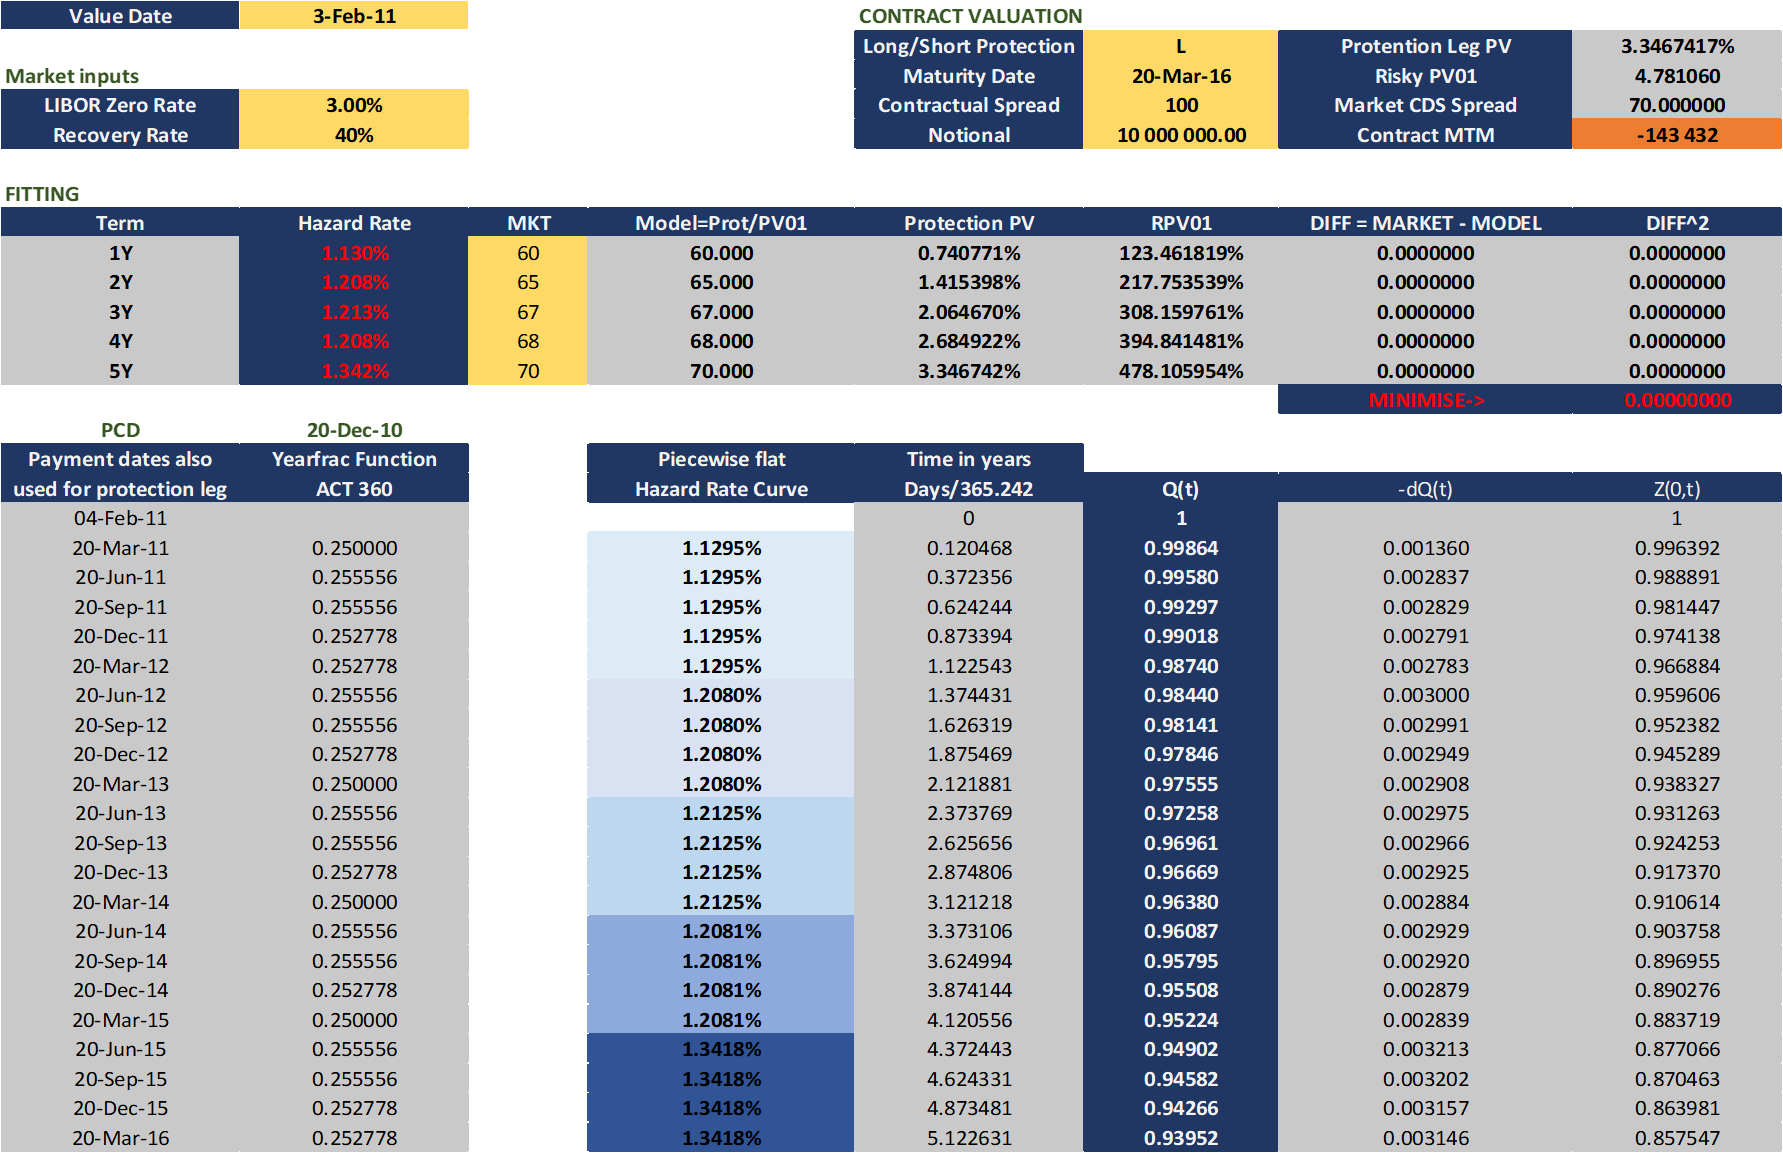

#### Q7.b Valuation at an other value date
We calibrated a model to construct a CDS spread curve using the survival probability **Q** defined as:
$$Q(0,T) = exp( \int_{0}^Th(s)ds ) $$
with ***h*** the hazard rate. We used a piecewise flat hazard rate as it is the market convention. <br>

Here are the other assumptions for our model:
- Day Count Convention: Act/360
- Swap Rate flat at 5%
- Initial time t_0 : 3/02/2011

Now, we will set today to be the 8th of December 2017 and build a CDS curve with the following points: **1Y - 65bp, 2Y - 69bp, 3Y - 75bp, 4Y - 80bp, 5Y - 83bp**. We will also use **40%** as a recovery rate.<br>
Here is what we get using Excel:

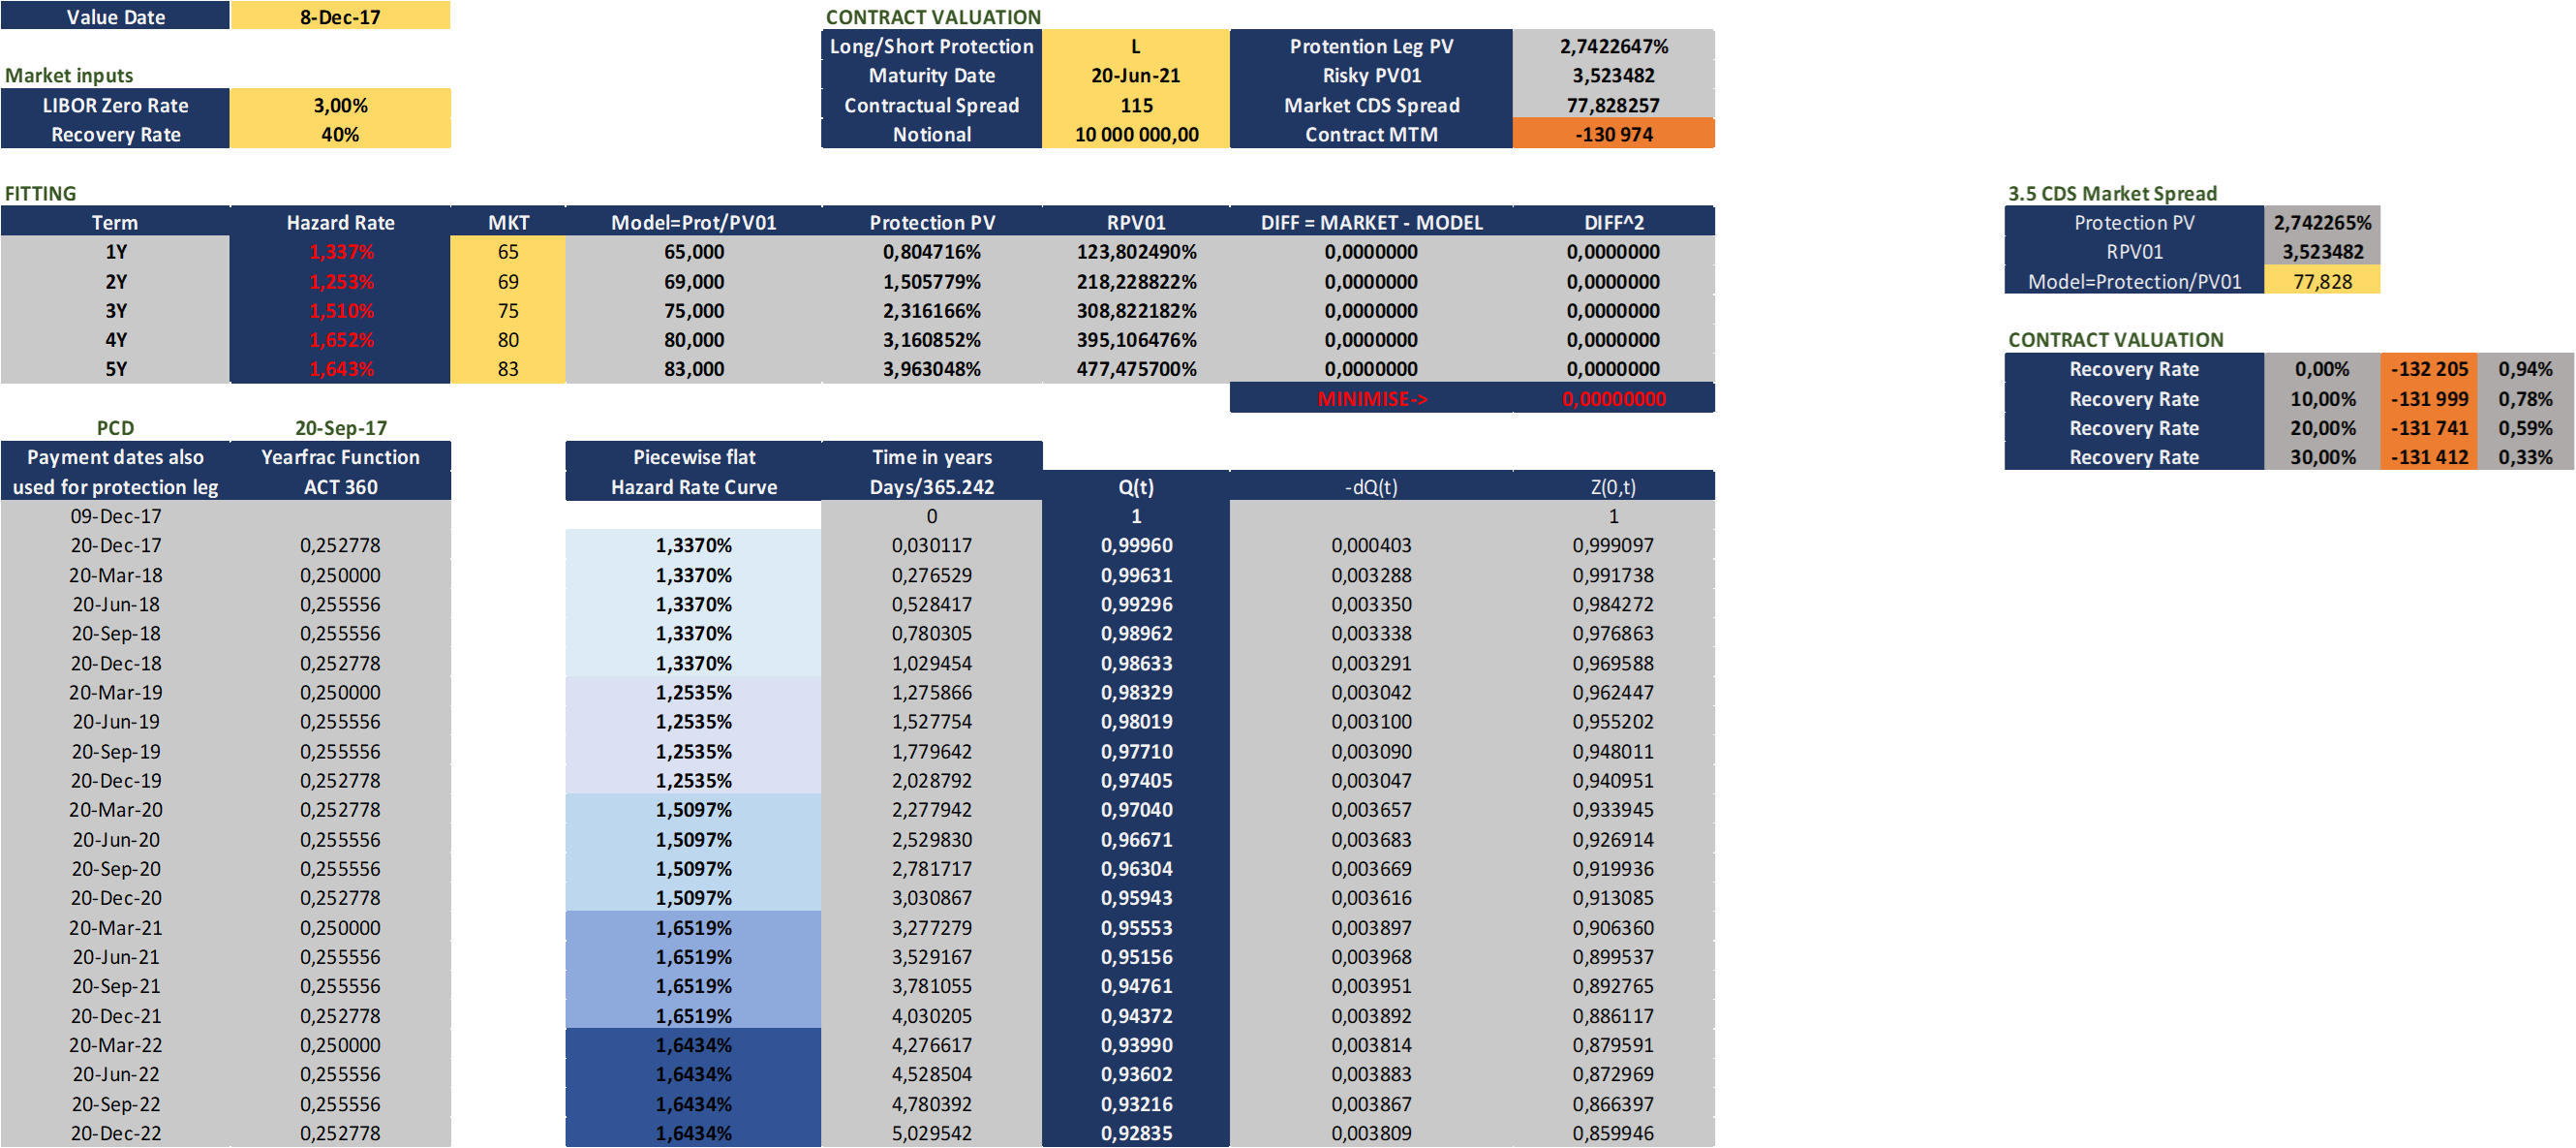

The CDS spread curve:

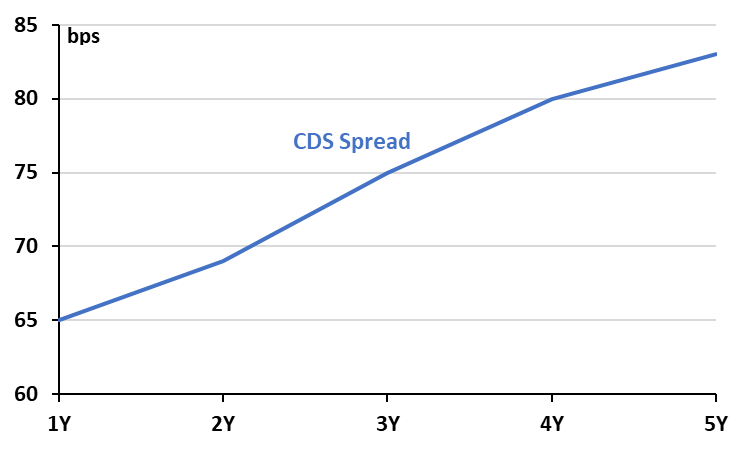

We have the following term structure of hazard rates (also in the Excel screen in different nuance of blue).

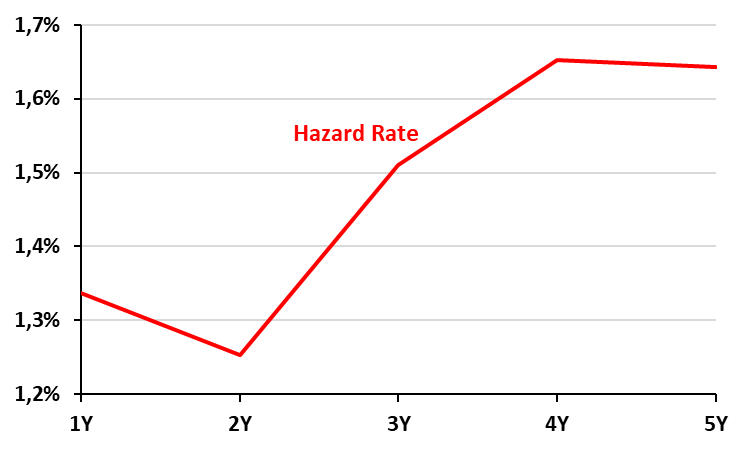

#### Q7.c Market spread of a CDS

We want to determine the market spread of a 3.5 Year CDS that matures on the 20 June 2021. To do so, we will use the following formula:
$$PV of Premium Leg = C * RPV01$$
To calculate RPV01 in Excel, we sumproduct the columns **Yearfrac**, **Q(t)** and **Z(0,T)**.
The market spread S is the rate C so that both the premium leg and the protection leg are equal. Hence:
$$S = \frac{PV of Protection Leg}{RPV01}$$
with $$PV of Protection Leg = (1-R)\int_{0}^TZ(t)(-dQ(t))$$
To calculate the present value of the protection leg in Excel, we multiply (1-Recovery rate) times sumproduct the columns **-dQ(t)** and **Z(0,T)**.

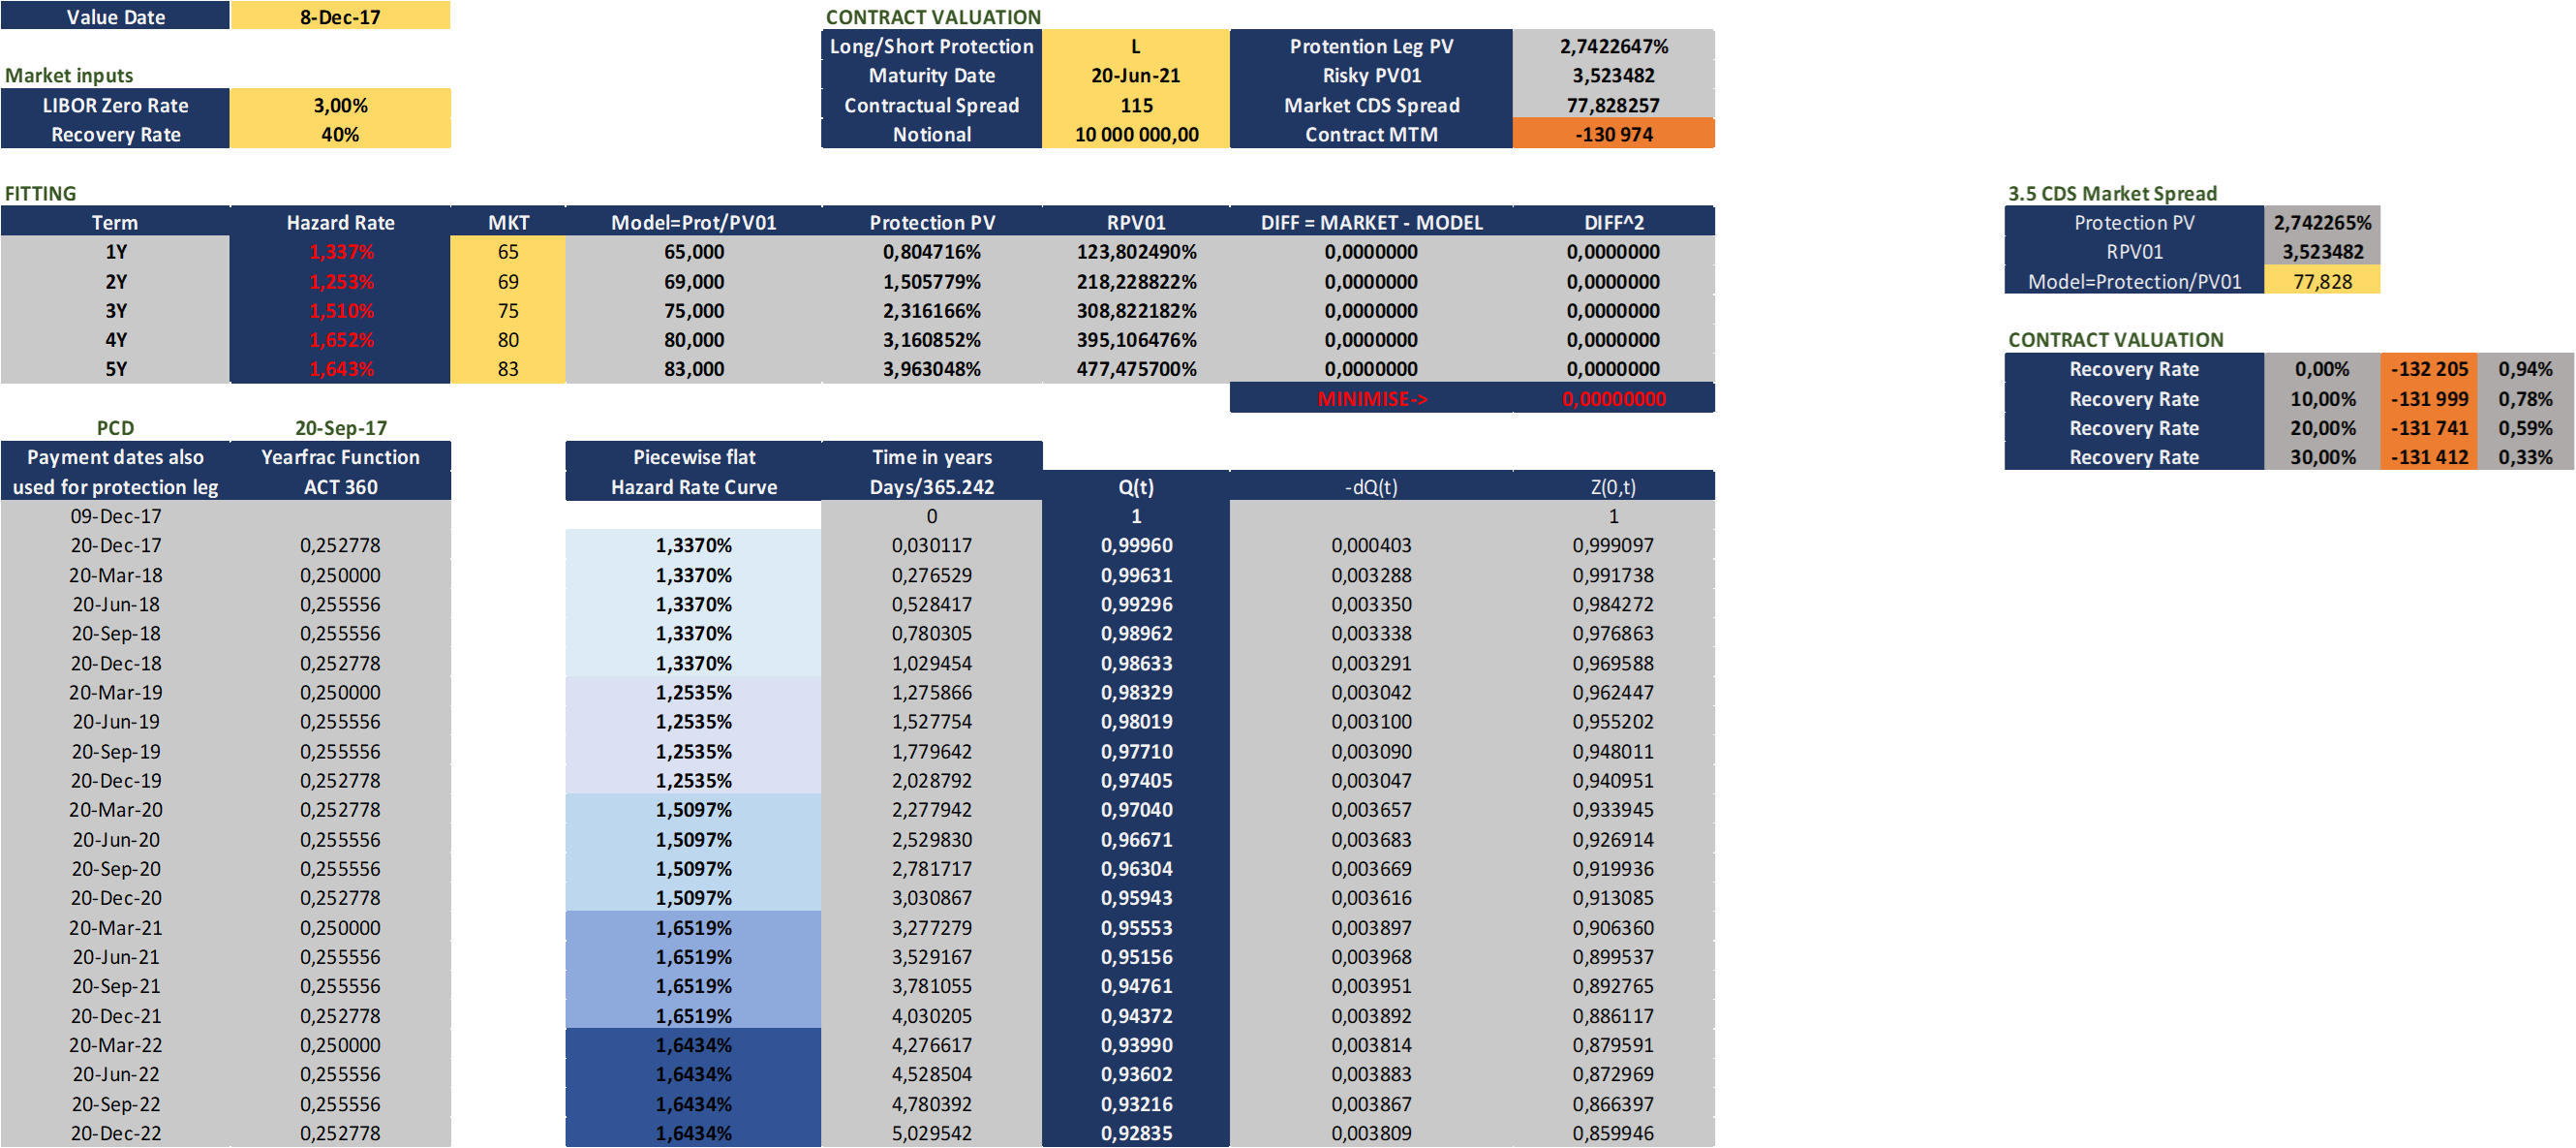

We obtain a 3.5 years CDS market spread of **77.828** basis points.

#### Q7.d Valuing a CDS contract on the market

We will calculate the value of an existing long protection CDS contract traded with a contractual spread of 115bp with a maturity of 20 June 2021 and a notional of $10m$.
<br> To do so, we change our **Contractual Spread** and **Notional** in ***Contract Valuation*** (top right) of our Excel:

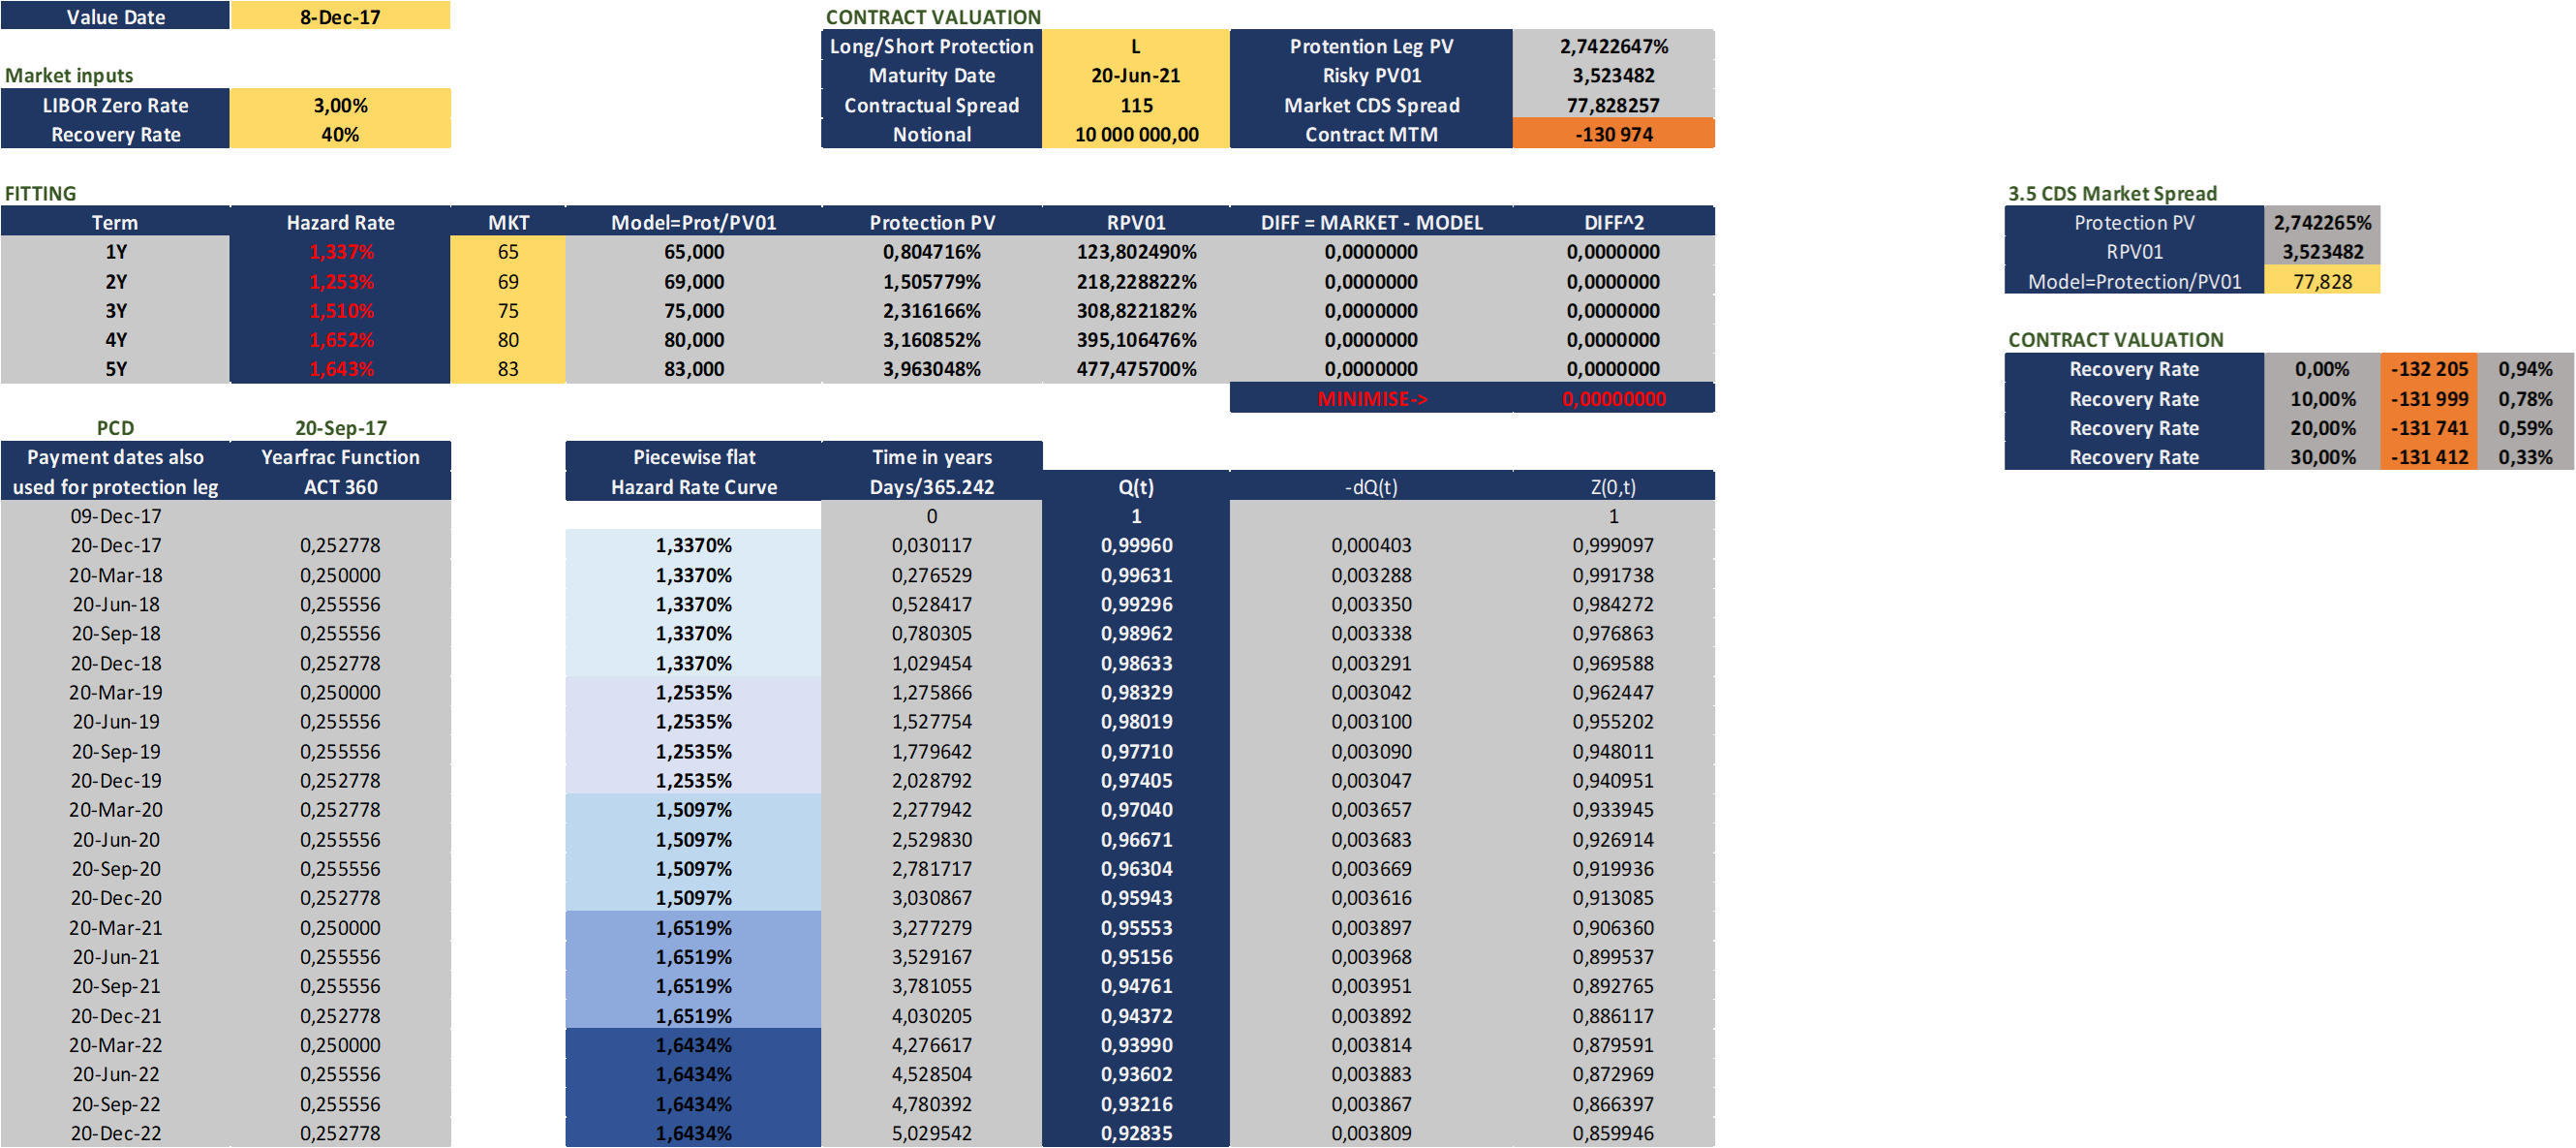

The contract is worth **$130.974**.

#### Q7.e Contract valuation for different recovery rates

Let's see how the value of the contract varies with the recovery rates:

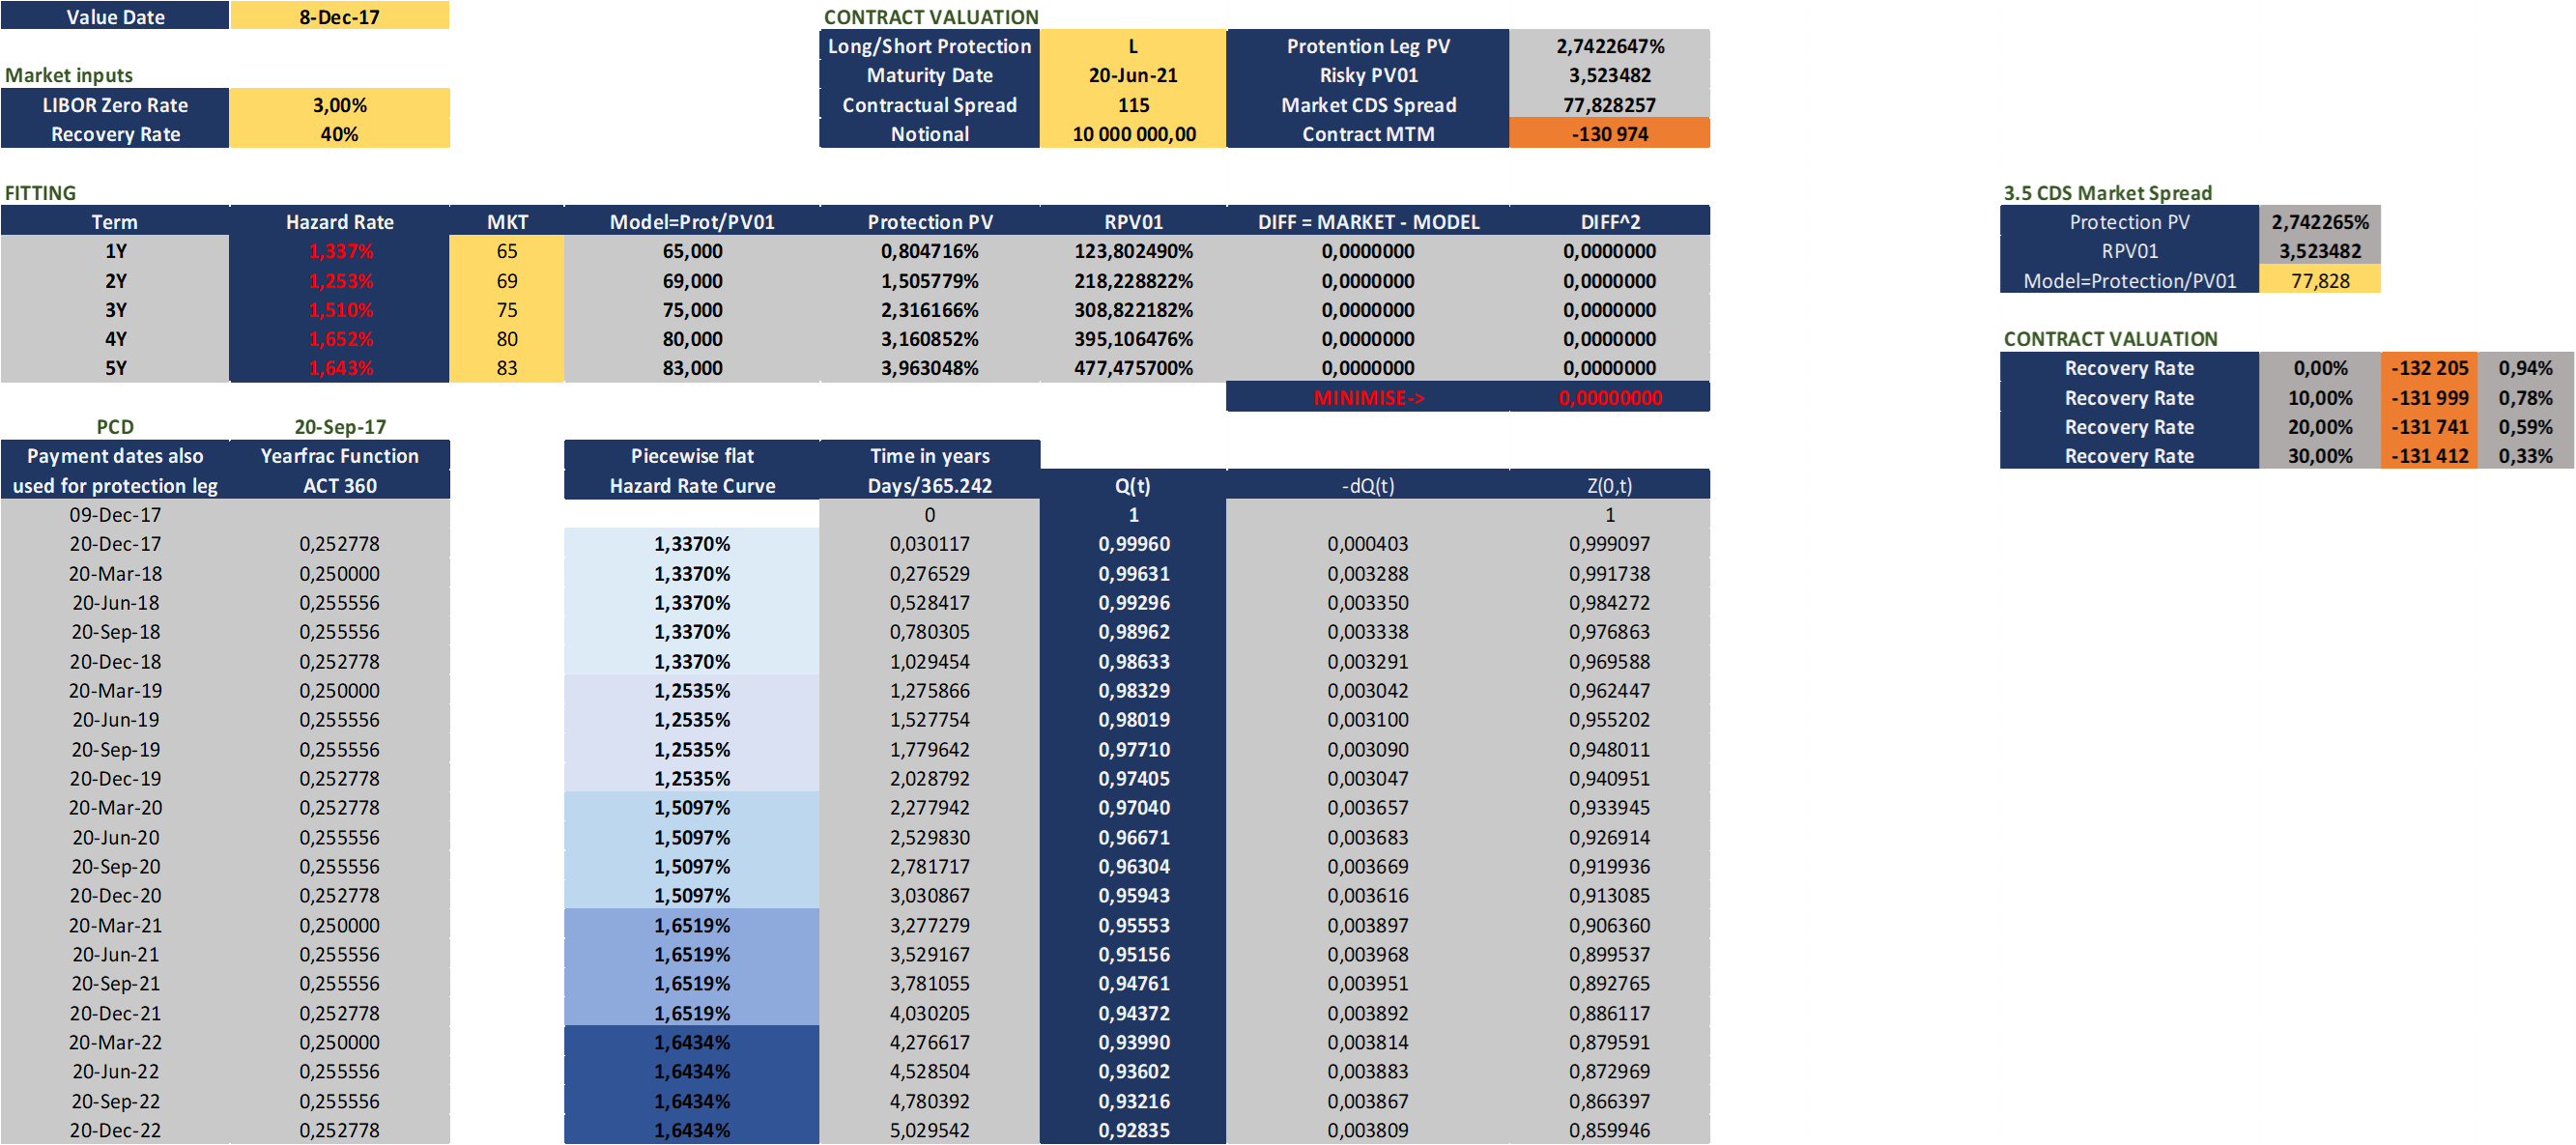

The changes in the contract valuation are not very significant although the recovery rate varies a lot. This is because as the recovery rate R changes, the hazard rates are recalculated so that the probabilities of survival balance themselves to fit the market spreads.
<br> Hence the **model is not very sensible to the recovery rate**.

#### Q7.f Contract valuation for 1bp bump in different CDS market rates

Let's see how the value of the contract varies with a 1bp increase in each of the 1Y, 2Y, 3Y, 4Y and 5Y CDS market rates:

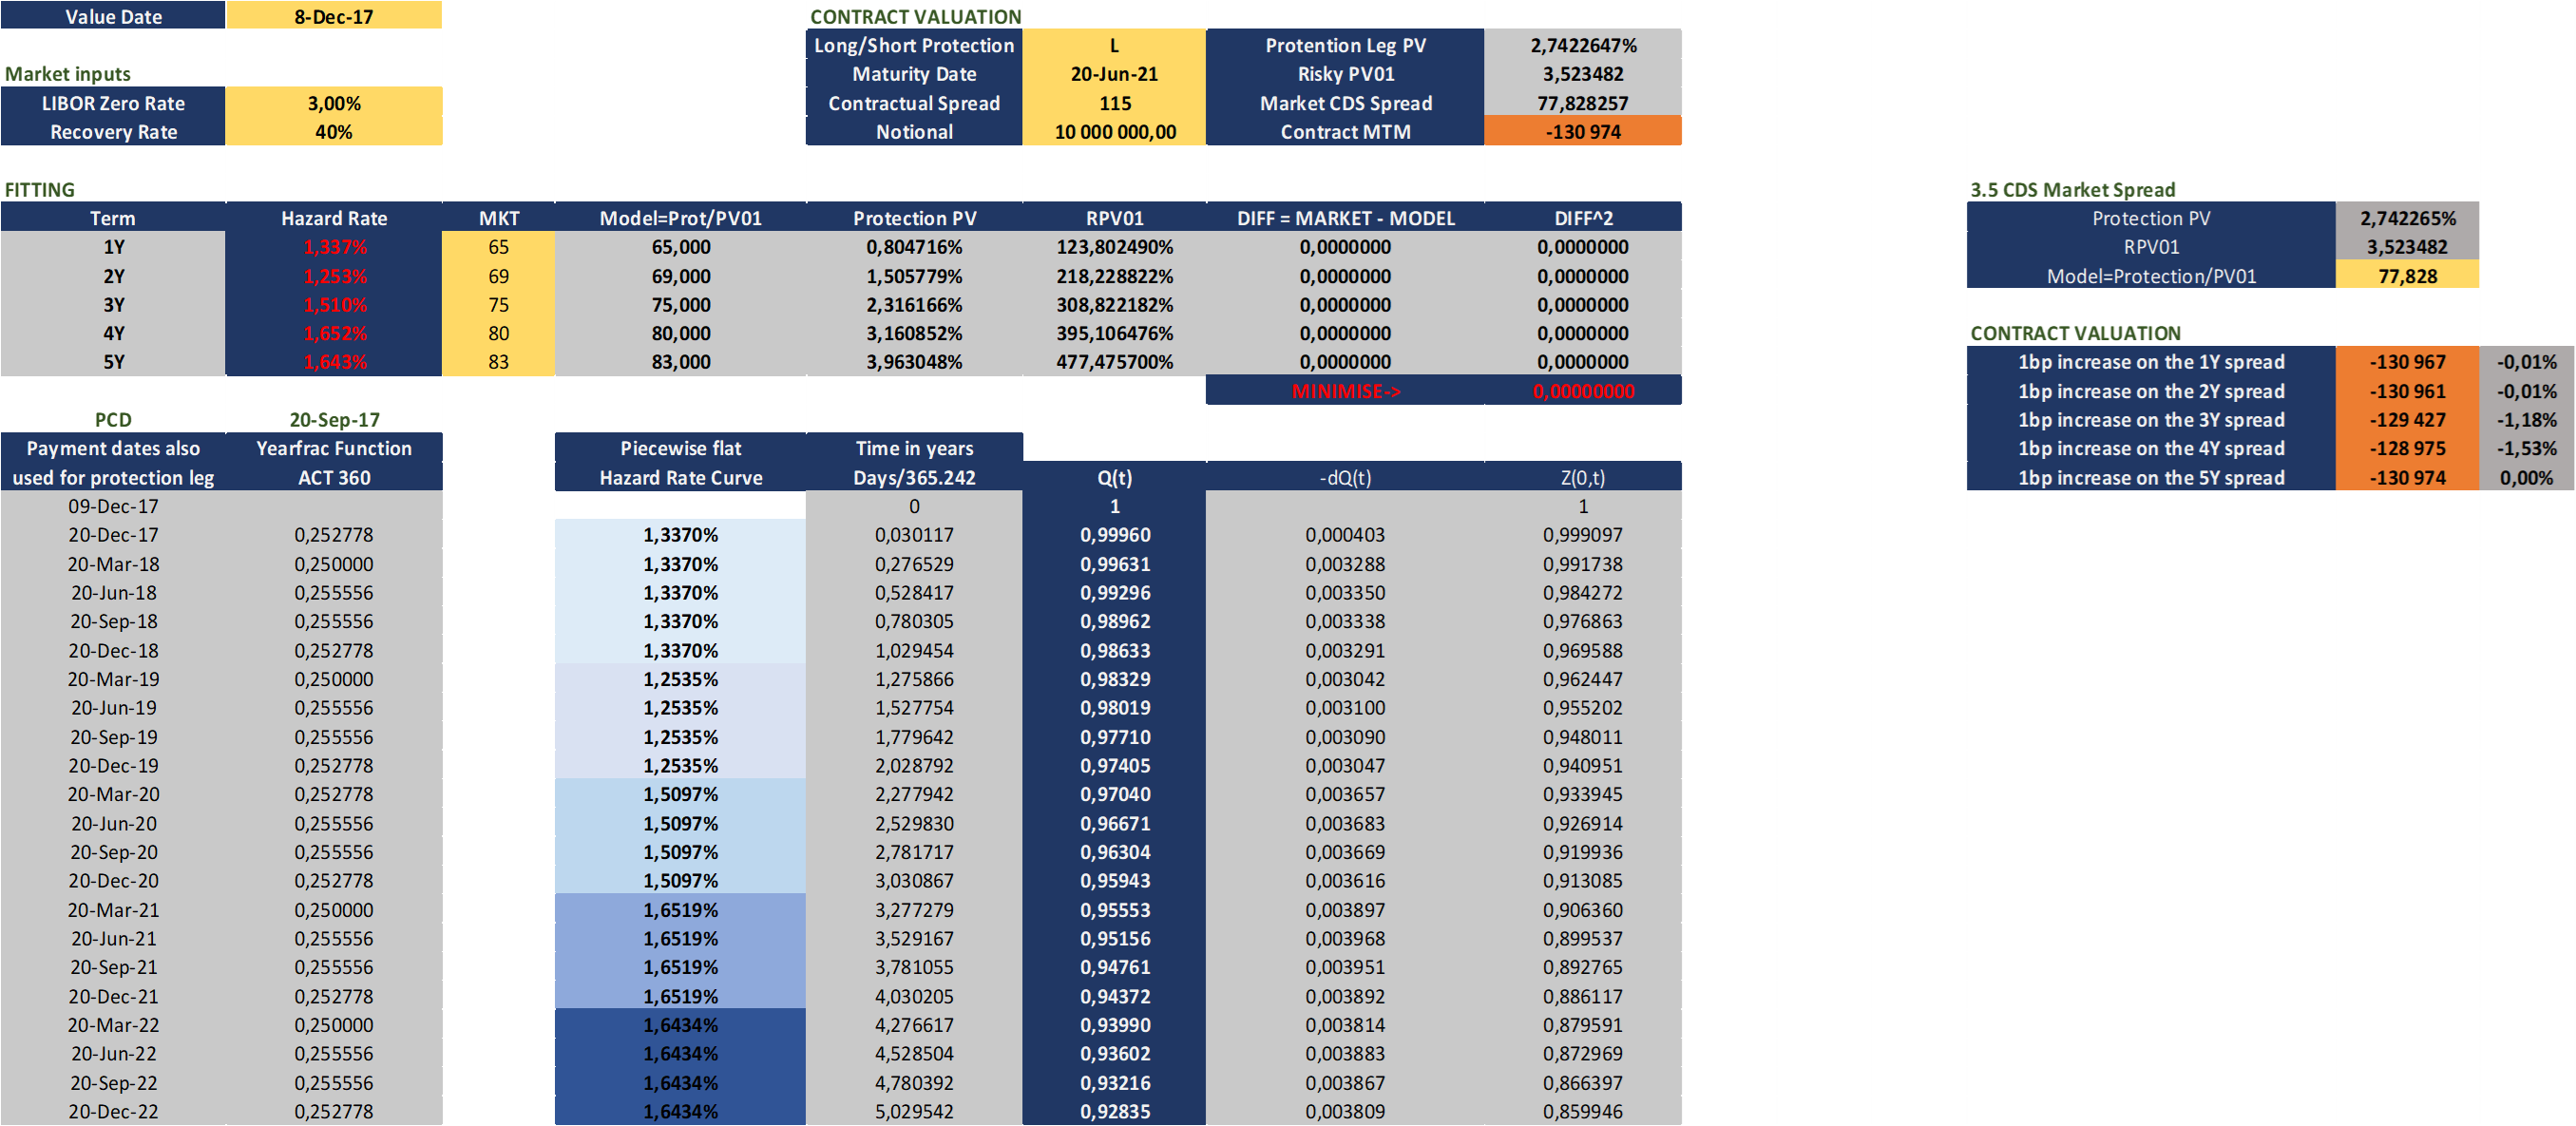

The changes are mainly located in the 3 and 4 years market spreads. They are the nearest maturities to our 3.5 years CDS contract.
<br> Hence, to hedge the position, a dealer could enter into both CDS maturing in 3 and 4 years. 
<br>The amount of the original contract and the hedging contract that should be held will be determined based on the sensitivity of the CDS to the change in the hedging contract spread. This sensitivity will be represented by a ratio of the changes in the original and hedging contracts in response to a change in the hedging contract spread. This ratio tells us how the CDS is affected by changes in the hedging contract spread.